# Set up

In [1]:
import pandas as pd
import patsy
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.backend import clear_session
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Getting data

In [2]:
file_name = '../csvs/element_gameweek_features_v06.csv'

In [3]:
element_gameweek_df = pd.read_csv(file_name)

In [4]:
current_event = 20

In [5]:
last_train_event = 15

In [6]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [7]:
element_gameweek_df.fillna(
    element_gameweek_df[element_gameweek_df['event'] <= last_train_event].mean(),
    inplace=True
)

In [8]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]

# Modelling data

## Splitting data

In [9]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [10]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.copy().iloc[train_index], element_gameweek_df.copy().iloc[test_index]

## Building model

In [11]:
formula = \
'total_points ~ C(element_type) + C(team) + C(opposition_team) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'minutes',
     'rolling_value_points',
     'total_points',
     
     'expected_total_points_against_opposition_team',
     'rolling_avg_total_points_element_home',
     'rolling_max_total_points_element',
     'rolling_avg_bps_element',
     'expected_total_points_element_home_away',
     'rolling_avg_total_points_element_away',
     'rolling_avg_total_points_own_team',
     'rolling_avg_total_points_against_opposition_team',
     'rolling_avg_minutes_element',
     'rolling_avg_total_points_opposition_team',
     'rolling_avg_dribbles_element',
     'rolling_avg_total_points_against_opposition_team_element_type',
     'rolling_avg_total_points_against_opposition_team_element_type_away',
     'rolling_avg_total_points_against_opposition_team_element_type_home',
     'rolling_avg_goals_conceded_element',
     'rolling_avg_completed_passes_element',
     'rolling_avg_total_points_element_type',
     'rolling_avg_recoveries_element',
 ]])

In [12]:
print(formula)

total_points ~ C(element_type) + C(team) + C(opposition_team) + was_home + is_sunday + is_weekday + is_early + is_late + value + rolling_avg_total_points_element + has_high_points_ever_element + rolling_avg_bonus_element + rolling_avg_goals_scored_element + rolling_avg_clean_sheets_element + rolling_avg_assists_element + rolling_avg_key_passes_element + rolling_avg_winning_goals_element + rolling_avg_tackled_element + rolling_avg_clearances_blocks_interceptions_element + rolling_avg_big_chances_created_element + rolling_avg_target_missed_element + rolling_avg_fouls_element + rolling_avg_tackles_element + rolling_avg_open_play_crosses_element + rolling_avg_offside_element + rolling_avg_big_chances_missed_element + rolling_avg_saves_element + rolling_avg_attempted_passes_element + rolling_avg_errors_leading_to_goal_element + rolling_avg_errors_leading_to_goal_attempt_element + rolling_avg_own_goals_element + rolling_avg_penalties_concededd_element + rolling_avg_penalties_missed_element +

In [13]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [14]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [15]:
X_sel = X
X_train_sel = X_train
X_test_sel = X_test

## Tuning model

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

### Helpers

In [16]:
def create_model(hidden_nodes,
                 hidden_layers,
                 dropout_rate,
                 weight_constraint
                ):
    model = Sequential()
    model.add(Dense(hidden_nodes,
                    activation='relu',
                    kernel_constraint=MaxNorm(weight_constraint)
                   ))
    
    
    for i in range(0, hidden_layers):
        model.add(Dropout(dropout_rate))
        model.add(Dense(hidden_nodes, activation='relu', kernel_constraint=MaxNorm(weight_constraint)))
        
        

    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

### GP tuner

In [67]:
space = [
    Real(10, 50, 'uniform', name='hidden_nodes'),
    Integer(0, 3, name='hidden_layers'),
    Real(10, 30, 'uniform', name='epochs'),
#     Real(20, 150, 'log-uniform', name='batch_size'),
    Real(0.1, 0.7, 'uniform', name='dropout_rate'),
    Integer(1, 5, name='weight_constraint')
]

In [68]:
@use_named_args(space)
def objective(hidden_nodes,
              hidden_layers,
              epochs,
              dropout_rate,
              weight_constraint
             ):
    
    model = create_model(
        hidden_nodes=int(hidden_nodes),
        hidden_layers=int(hidden_layers),
        dropout_rate=dropout_rate,
        weight_constraint=weight_constraint
    )
    
    model.fit(X_train_sel,
              y_train.ravel(),
              epochs=int(epochs),
              batch_size=20)
    
    y_pred = model.predict(X_test_sel).flatten()
    test_loss = mean_squared_error(y_test, y_pred)

    del model
    clear_session()
    
    return test_loss

In [69]:
res_gp_arr = []
for i in range(1, 11):
    print('minimisation iteration', i)
    res_gp = gp_minimize(objective, space, n_calls=50, verbose=2)
    res_gp_arr.append(res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Epoch 1/16
2696/2696 [==============================] - 1s 522us/sample - loss: 46.9446
Epoch 2/16
2696/2696 [==============================] - 0s 74us/sample - loss: 13.3755
Epoch 3/16
2696/2696 [==============================] - 0s 74us/sample - loss: 10.5805
Epoch 4/16
2696/2696 [==============================] - 0s 73us/sample - loss: 9.9017
Epoch 5/16
2696/2696 [==============================] - 0s 74us/sample - loss: 9.7884
Epoch 6/16
2696/2696 [==============================] - 0s 74us/sample - loss: 9.4971
Epoch 7/16
2696/2696 [==============================] - 0s 73us/sample - loss: 9.5905
Epoch 8/16
2696/2696 [==============================] - 0s 74us/sample - loss: 9.3352
Epoch 9/16
2696/2696 [==============================] - 0s 73us/sample - loss: 9.2282
Epoch 10/16
2696/2696 [==============================] - 0s 74us/sample - loss: 9.0563
Epoch 11/16
2696/2696 [=========================

Epoch 1/28
2696/2696 [==============================] - 1s 204us/sample - loss: 23.6348
Epoch 2/28
2696/2696 [==============================] - 0s 76us/sample - loss: 11.5515
Epoch 3/28
2696/2696 [==============================] - 0s 76us/sample - loss: 10.2254
Epoch 4/28
2696/2696 [==============================] - 0s 76us/sample - loss: 9.7747
Epoch 5/28
2696/2696 [==============================] - 0s 77us/sample - loss: 9.4677
Epoch 6/28
2696/2696 [==============================] - 0s 76us/sample - loss: 9.2571
Epoch 7/28
2696/2696 [==============================] - 0s 77us/sample - loss: 9.3946
Epoch 8/28
2696/2696 [==============================] - 0s 76us/sample - loss: 9.3043
Epoch 9/28
2696/2696 [==============================] - 0s 78us/sample - loss: 9.0869
Epoch 10/28
2696/2696 [==============================] - 0s 76us/sample - loss: 9.0714
Epoch 11/28
2696/2696 [==============================] - 0s 77us/sample - loss: 9.0716
Epoch 12/28
2696/2696 [=========================

2696/2696 [==============================] - 0s 67us/sample - loss: 8.4811
Epoch 23/29
2696/2696 [==============================] - 0s 67us/sample - loss: 8.4590
Epoch 24/29
2696/2696 [==============================] - 0s 67us/sample - loss: 8.3723
Epoch 25/29
2696/2696 [==============================] - 0s 66us/sample - loss: 8.4126
Epoch 26/29
2696/2696 [==============================] - 0s 67us/sample - loss: 8.3865
Epoch 27/29
2696/2696 [==============================] - 0s 67us/sample - loss: 8.4042
Epoch 28/29
2696/2696 [==============================] - 0s 66us/sample - loss: 8.2699
Epoch 29/29
2696/2696 [==============================] - 0s 66us/sample - loss: 8.3431
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 6.1688
Function value obtained: 9.6305
Current minimum: 9.6305
Iteration No: 9 started. Evaluating function at random point.
Epoch 1/27
2696/2696 [==============================] - 0s 171us/sample - loss: 12.7685
Epoch 2/27
2696/2696 [=============

2696/2696 [==============================] - 0s 64us/sample - loss: 8.4892
Epoch 26/29
2696/2696 [==============================] - 0s 65us/sample - loss: 8.3652
Epoch 27/29
2696/2696 [==============================] - 0s 65us/sample - loss: 8.3632
Epoch 28/29
2696/2696 [==============================] - 0s 65us/sample - loss: 8.2941
Epoch 29/29
2696/2696 [==============================] - 0s 65us/sample - loss: 8.3927
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 6.8402
Function value obtained: 9.5761
Current minimum: 9.5761
Iteration No: 12 started. Searching for the next optimal point.
Epoch 1/30
2696/2696 [==============================] - 0s 133us/sample - loss: 11.7464
Epoch 2/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.6784
Epoch 3/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.5106
Epoch 4/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.4367
Epoch 5/30
2696/2696 [==

2696/2696 [==============================] - 0s 56us/sample - loss: 8.1546
Epoch 17/26
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2765
Epoch 18/26
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2578
Epoch 19/26
2696/2696 [==============================] - 0s 56us/sample - loss: 8.1437
Epoch 20/26
2696/2696 [==============================] - 0s 56us/sample - loss: 8.5770
Epoch 21/26
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4640
Epoch 22/26
2696/2696 [==============================] - 0s 57us/sample - loss: 8.2934
Epoch 23/26
2696/2696 [==============================] - 0s 56us/sample - loss: 8.1455
Epoch 24/26
2696/2696 [==============================] - 0s 56us/sample - loss: 8.1811
Epoch 25/26
2696/2696 [==============================] - 0s 59us/sample - loss: 8.1174
Epoch 26/26
2696/2696 [==============================] - 0s 56us/sample - loss: 8.1898
Iteration No: 15 ended. Search finished for the next op

2696/2696 [==============================] - 0s 58us/sample - loss: 8.1252
Epoch 19/28
2696/2696 [==============================] - 0s 60us/sample - loss: 8.1422
Epoch 20/28
2696/2696 [==============================] - 0s 57us/sample - loss: 8.1855
Epoch 21/28
2696/2696 [==============================] - 0s 57us/sample - loss: 8.3010
Epoch 22/28
2696/2696 [==============================] - 0s 57us/sample - loss: 8.2152
Epoch 23/28
2696/2696 [==============================] - 0s 57us/sample - loss: 8.2339
Epoch 24/28
2696/2696 [==============================] - 0s 57us/sample - loss: 8.3947
Epoch 25/28
2696/2696 [==============================] - 0s 57us/sample - loss: 8.1192
Epoch 26/28
2696/2696 [==============================] - 0s 58us/sample - loss: 8.2019
Epoch 27/28
2696/2696 [==============================] - 0s 57us/sample - loss: 8.3610
Epoch 28/28
2696/2696 [==============================] - 0s 57us/sample - loss: 8.2047
Iteration No: 19 ended. Search finished for the next op

2696/2696 [==============================] - 0s 66us/sample - loss: 8.5785
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 4.3343
Function value obtained: 10.2350
Current minimum: 9.5517
Iteration No: 24 started. Searching for the next optimal point.
Epoch 1/28
2696/2696 [==============================] - 0s 132us/sample - loss: 10.3510
Epoch 2/28
2696/2696 [==============================] - 0s 57us/sample - loss: 8.6615
Epoch 3/28
2696/2696 [==============================] - 0s 56us/sample - loss: 8.6600
Epoch 4/28
2696/2696 [==============================] - 0s 56us/sample - loss: 8.6118
Epoch 5/28
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4306
Epoch 6/28
2696/2696 [==============================] - 0s 60us/sample - loss: 8.4873
Epoch 7/28
2696/2696 [==============================] - 0s 57us/sample - loss: 8.3668
Epoch 8/28
2696/2696 [==============================] - 0s 57us/sample - loss: 8.2610
Epoch 9/28
2696/2696 [=====

2696/2696 [==============================] - 0s 58us/sample - loss: 8.2661
Epoch 9/30
2696/2696 [==============================] - 0s 58us/sample - loss: 8.4293
Epoch 10/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.2284
Epoch 11/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.2428
Epoch 12/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.3661
Epoch 13/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.2917
Epoch 14/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.2365
Epoch 15/30
2696/2696 [==============================] - 0s 58us/sample - loss: 8.2389
Epoch 16/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.4456
Epoch 17/30
2696/2696 [==============================] - 0s 58us/sample - loss: 8.2081
Epoch 18/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.3419
Epoch 19/30
2696/2696 [==============================] -

2696/2696 [==============================] - 0s 64us/sample - loss: 8.5374
Epoch 26/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.5628
Epoch 27/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.5972
Epoch 28/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.4332
Epoch 29/30
2696/2696 [==============================] - 0s 64us/sample - loss: 8.4821
Epoch 30/30
2696/2696 [==============================] - 0s 64us/sample - loss: 8.4054
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 7.9774
Function value obtained: 9.7004
Current minimum: 9.5449
Iteration No: 32 started. Searching for the next optimal point.
Epoch 1/30
2696/2696 [==============================] - 0s 172us/sample - loss: 23.6193
Epoch 2/30
2696/2696 [==============================] - 0s 67us/sample - loss: 10.8643
Epoch 3/30
2696/2696 [==============================] - 0s 67us/sample - loss: 9.6086
Epoch 4/30
2696/2696 [

2696/2696 [==============================] - 0s 67us/sample - loss: 8.6366
Epoch 11/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.5403
Epoch 12/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.4998
Epoch 13/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.4142
Epoch 14/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.5576
Epoch 15/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.3107
Epoch 16/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.2966
Epoch 17/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.3443
Epoch 18/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.2266
Epoch 19/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.3052
Epoch 20/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.1582
Epoch 21/30
2696/2696 [==============================] 

2696/2696 [==============================] - 0s 67us/sample - loss: 8.9440
Epoch 8/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.7700
Epoch 9/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.7559
Epoch 10/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.8189
Epoch 11/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.4816
Epoch 12/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.5378
Epoch 13/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.5266
Epoch 14/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.4777
Epoch 15/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.4418
Epoch 16/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.2665
Epoch 17/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.4582
Epoch 18/30
2696/2696 [==============================] - 

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/30
2696/2696 [==============================] - 0s 178us/sample - loss: 11.6391
Epoch 2/30
2696/2696 [==============================] - 0s 68us/sample - loss: 9.3731
Epoch 3/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.9253
Epoch 4/30
2696/2696 [==============================] - 0s 69us/sample - loss: 8.8724
Epoch 5/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.7982
Epoch 6/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.9476
Epoch 7/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.8060
Epoch 8/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.6362
Epoch 9/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.6019
Epoch 10/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.5049
Epoch 11/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.5108
Epoch 12/30
2696/2696 [===========================

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/30
2696/2696 [==============================] - 0s 173us/sample - loss: 16.9302
Epoch 2/30
2696/2696 [==============================] - 0s 68us/sample - loss: 9.6971
Epoch 3/30
2696/2696 [==============================] - 0s 67us/sample - loss: 9.2812
Epoch 4/30
2696/2696 [==============================] - 0s 67us/sample - loss: 9.3698
Epoch 5/30
2696/2696 [==============================] - 0s 67us/sample - loss: 9.1493
Epoch 6/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.9381
Epoch 7/30
2696/2696 [==============================] - 0s 67us/sample - loss: 9.0113
Epoch 8/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.7610
Epoch 9/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.7195
Epoch 10/30
2696/2696 [==============================] - 0s 69us/sample - loss: 8.6254
Epoch 11/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.6099
Epoch 12/30
2696/2696 [===========================

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/30
2696/2696 [==============================] - 0s 171us/sample - loss: 11.8237
Epoch 2/30
2696/2696 [==============================] - 0s 67us/sample - loss: 9.7362
Epoch 3/30
2696/2696 [==============================] - 0s 67us/sample - loss: 9.2740
Epoch 4/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.8890
Epoch 5/30
2696/2696 [==============================] - 0s 67us/sample - loss: 9.0310
Epoch 6/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.7569
Epoch 7/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.7841
Epoch 8/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.7506
Epoch 9/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.6704
Epoch 10/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.5746
Epoch 11/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.5817
Epoch 12/30
2696/2696 [===========================

2696/2696 [==============================] - 0s 66us/sample - loss: 8.1238
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 7.7562
Function value obtained: 9.5769
Current minimum: 9.4443
Iteration No: 46 started. Searching for the next optimal point.
Epoch 1/30
2696/2696 [==============================] - 0s 173us/sample - loss: 24.7803
Epoch 2/30
2696/2696 [==============================] - 0s 66us/sample - loss: 9.4612
Epoch 3/30
2696/2696 [==============================] - 0s 66us/sample - loss: 8.8912
Epoch 4/30
2696/2696 [==============================] - 0s 66us/sample - loss: 9.1208
Epoch 5/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.7833
Epoch 6/30
2696/2696 [==============================] - 0s 66us/sample - loss: 8.7070
Epoch 7/30
2696/2696 [==============================] - 0s 66us/sample - loss: 8.8595
Epoch 8/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.6676
Epoch 9/30
2696/2696 [======

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/30
2696/2696 [==============================] - 0s 173us/sample - loss: 16.6119
Epoch 2/30
2696/2696 [==============================] - 0s 65us/sample - loss: 9.9238
Epoch 3/30
2696/2696 [==============================] - 0s 65us/sample - loss: 9.0644
Epoch 4/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.8787
Epoch 5/30
2696/2696 [==============================] - 0s 65us/sample - loss: 9.0289
Epoch 6/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.8456
Epoch 7/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.6676
Epoch 8/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.6311
Epoch 9/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.6403
Epoch 10/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.5766
Epoch 11/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.5838
Epoch 12/30
2696/2696 [===========================

2696/2696 [==============================] - 0s 66us/sample - loss: 8.2506
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 8.0445
Function value obtained: 9.3485
Current minimum: 9.3485
Iteration No: 50 started. Searching for the next optimal point.
Epoch 1/30
2696/2696 [==============================] - 0s 176us/sample - loss: 11.9628
Epoch 2/30
2696/2696 [==============================] - 0s 66us/sample - loss: 9.6348
Epoch 3/30
2696/2696 [==============================] - 0s 66us/sample - loss: 9.0567
Epoch 4/30
2696/2696 [==============================] - 0s 66us/sample - loss: 8.9972
Epoch 5/30
2696/2696 [==============================] - 0s 66us/sample - loss: 8.7683
Epoch 6/30
2696/2696 [==============================] - 0s 66us/sample - loss: 8.8462
Epoch 7/30
2696/2696 [==============================] - 0s 66us/sample - loss: 8.6504
Epoch 8/30
2696/2696 [==============================] - 0s 66us/sample - loss: 8.7405
Epoch 9/30
2696/2696 [======

2696/2696 [==============================] - 0s 84us/sample - loss: 9.0127
Epoch 26/29
2696/2696 [==============================] - 0s 84us/sample - loss: 9.0559
Epoch 27/29
2696/2696 [==============================] - 0s 84us/sample - loss: 8.9048
Epoch 28/29
2696/2696 [==============================] - 0s 84us/sample - loss: 9.0129
Epoch 29/29
2696/2696 [==============================] - 0s 89us/sample - loss: 8.9524
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 8.4822
Function value obtained: 10.0230
Current minimum: 9.9657
Iteration No: 4 started. Evaluating function at random point.
Epoch 1/25
2696/2696 [==============================] - 1s 262us/sample - loss: 18.0921
Epoch 2/25
2696/2696 [==============================] - 0s 87us/sample - loss: 10.7269
Epoch 3/25
2696/2696 [==============================] - 0s 87us/sample - loss: 10.2473
Epoch 4/25
2696/2696 [==============================] - 0s 87us/sample - loss: 9.7553
Epoch 5/25
2696/2696 [=============

2696/2696 [==============================] - 0s 76us/sample - loss: 10.6815
Epoch 6/21
2696/2696 [==============================] - 0s 76us/sample - loss: 10.3064
Epoch 7/21
2696/2696 [==============================] - 0s 76us/sample - loss: 10.2444
Epoch 8/21
2696/2696 [==============================] - 0s 76us/sample - loss: 10.1249
Epoch 9/21
2696/2696 [==============================] - 0s 76us/sample - loss: 9.8172
Epoch 10/21
2696/2696 [==============================] - 0s 76us/sample - loss: 9.5181
Epoch 11/21
2696/2696 [==============================] - 0s 75us/sample - loss: 9.4576
Epoch 12/21
2696/2696 [==============================] - 0s 77us/sample - loss: 9.4567
Epoch 13/21
2696/2696 [==============================] - 0s 76us/sample - loss: 9.3147
Epoch 14/21
2696/2696 [==============================] - 0s 76us/sample - loss: 9.3799
Epoch 15/21
2696/2696 [==============================] - 0s 76us/sample - loss: 9.0729
Epoch 16/21
2696/2696 [==============================] 

2696/2696 [==============================] - 0s 75us/sample - loss: 9.0782
Epoch 26/28
2696/2696 [==============================] - 0s 75us/sample - loss: 9.0877
Epoch 27/28
2696/2696 [==============================] - 0s 75us/sample - loss: 9.2200
Epoch 28/28
2696/2696 [==============================] - 0s 74us/sample - loss: 8.9979
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 7.7818
Function value obtained: 10.4969
Current minimum: 9.6754
Iteration No: 11 started. Searching for the next optimal point.
Epoch 1/30
2696/2696 [==============================] - 1s 215us/sample - loss: 11.9953
Epoch 2/30
2696/2696 [==============================] - 0s 81us/sample - loss: 9.2628
Epoch 3/30
2696/2696 [==============================] - 0s 77us/sample - loss: 9.0486
Epoch 4/30
2696/2696 [==============================] - 0s 77us/sample - loss: 9.0126
Epoch 5/30
2696/2696 [==============================] - 0s 77us/sample - loss: 9.0004
Epoch 6/30
2696/2696 [=============

2696/2696 [==============================] - 0s 88us/sample - loss: 8.6691
Epoch 25/30
2696/2696 [==============================] - 0s 91us/sample - loss: 8.6805
Epoch 26/30
2696/2696 [==============================] - 0s 88us/sample - loss: 8.5889
Epoch 27/30
2696/2696 [==============================] - 0s 88us/sample - loss: 8.4695
Epoch 28/30
2696/2696 [==============================] - 0s 88us/sample - loss: 8.5042
Epoch 29/30
2696/2696 [==============================] - 0s 88us/sample - loss: 8.5189
Epoch 30/30
2696/2696 [==============================] - 0s 88us/sample - loss: 8.4996
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 9.7938
Function value obtained: 10.0884
Current minimum: 9.5605
Iteration No: 14 started. Searching for the next optimal point.
Epoch 1/11
2696/2696 [==============================] - 1s 254us/sample - loss: 10.6564
Epoch 2/11
2696/2696 [==============================] - 0s 88us/sample - loss: 9.4300
Epoch 3/11
2696/2696 

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/30
2696/2696 [==============================] - 1s 215us/sample - loss: 10.8997
Epoch 2/30
2696/2696 [==============================] - 0s 79us/sample - loss: 9.2296
Epoch 3/30
2696/2696 [==============================] - 0s 78us/sample - loss: 9.2451
Epoch 4/30
2696/2696 [==============================] - 0s 77us/sample - loss: 8.9701
Epoch 5/30
2696/2696 [==============================] - 0s 78us/sample - loss: 9.0532
Epoch 6/30
2696/2696 [==============================] - 0s 79us/sample - loss: 8.9161
Epoch 7/30
2696/2696 [==============================] - 0s 77us/sample - loss: 8.7691
Epoch 8/30
2696/2696 [==============================] - 0s 78us/sample - loss: 8.7024
Epoch 9/30
2696/2696 [==============================] - 0s 78us/sample - loss: 8.6975
Epoch 10/30
2696/2696 [==============================] - 0s 78us/sample - loss: 8.5753
Epoch 11/30
2696/2696 [==============================] - 0s 78us/sample - loss: 8.5593
Epoch 12/30
2696/2696 [===========================

2696/2696 [==============================] - 0s 56us/sample - loss: 8.2861
Epoch 13/19
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2518
Epoch 14/19
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2054
Epoch 15/19
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3039
Epoch 16/19
2696/2696 [==============================] - 0s 56us/sample - loss: 8.5154
Epoch 17/19
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3665
Epoch 18/19
2696/2696 [==============================] - 0s 56us/sample - loss: 8.1970
Epoch 19/19
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2535
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 5.3631
Function value obtained: 9.9317
Current minimum: 9.5433
Iteration No: 21 started. Searching for the next optimal point.
Epoch 1/30
2696/2696 [==============================] - 1s 258us/sample - loss: 9.7169
Epoch 2/30
2696/2696 [

2696/2696 [==============================] - 0s 87us/sample - loss: 8.8661
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 5.5633
Function value obtained: 10.5342
Current minimum: 9.4698
Iteration No: 26 started. Searching for the next optimal point.
Epoch 1/10
2696/2696 [==============================] - 0s 174us/sample - loss: 11.0802
Epoch 2/10
2696/2696 [==============================] - 0s 67us/sample - loss: 9.2383
Epoch 3/10
2696/2696 [==============================] - 0s 67us/sample - loss: 8.9368
Epoch 4/10
2696/2696 [==============================] - 0s 67us/sample - loss: 8.9453
Epoch 5/10
2696/2696 [==============================] - 0s 68us/sample - loss: 8.8028
Epoch 6/10
2696/2696 [==============================] - 0s 67us/sample - loss: 8.6935
Epoch 7/10
2696/2696 [==============================] - 0s 67us/sample - loss: 8.6944
Epoch 8/10
2696/2696 [==============================] - 0s 67us/sample - loss: 8.6041
Epoch 9/10
2696/2696 [=====

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/10
2696/2696 [==============================] - 0s 183us/sample - loss: 11.2720
Epoch 2/10
2696/2696 [==============================] - 0s 69us/sample - loss: 9.2735 0s - loss: 9.22
Epoch 3/10
2696/2696 [==============================] - 0s 68us/sample - loss: 8.9822
Epoch 4/10
2696/2696 [==============================] - 0s 67us/sample - loss: 9.0665
Epoch 5/10
2696/2696 [==============================] - 0s 68us/sample - loss: 8.9595
Epoch 6/10
2696/2696 [==============================] - 0s 67us/sample - loss: 8.7235
Epoch 7/10
2696/2696 [==============================] - 0s 67us/sample - loss: 8.6999
Epoch 8/10
2696/2696 [==============================] - 0s 67us/sample - loss: 8.5531
Epoch 9/10
2696/2696 [==============================] - 0s 67us/sample - loss: 8.5534
Epoch 10/10
2696/2696 [==============================] - 0s 68us/sample - loss: 8.5750
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 3.8914
Function value obtained: 9.7105
Cu

2696/2696 [==============================] - 0s 78us/sample - loss: 9.2110
Epoch 3/23
2696/2696 [==============================] - 0s 79us/sample - loss: 8.9255
Epoch 4/23
2696/2696 [==============================] - 0s 78us/sample - loss: 8.8838
Epoch 5/23
2696/2696 [==============================] - 0s 78us/sample - loss: 8.8823
Epoch 6/23
2696/2696 [==============================] - 0s 78us/sample - loss: 8.7853
Epoch 7/23
2696/2696 [==============================] - 0s 78us/sample - loss: 8.7686
Epoch 8/23
2696/2696 [==============================] - 0s 78us/sample - loss: 8.6411
Epoch 9/23
2696/2696 [==============================] - 0s 78us/sample - loss: 8.5342
Epoch 10/23
2696/2696 [==============================] - 0s 78us/sample - loss: 8.6217
Epoch 11/23
2696/2696 [==============================] - 0s 78us/sample - loss: 8.5235
Epoch 12/23
2696/2696 [==============================] - 0s 78us/sample - loss: 8.5710
Epoch 13/23
2696/2696 [==============================] - 0s 78

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/10
2696/2696 [==============================] - 0s 135us/sample - loss: 10.6047
Epoch 2/10
2696/2696 [==============================] - 0s 59us/sample - loss: 8.6106
Epoch 3/10
2696/2696 [==============================] - 0s 58us/sample - loss: 8.4758
Epoch 4/10
2696/2696 [==============================] - 0s 57us/sample - loss: 8.4390
Epoch 5/10
2696/2696 [==============================] - 0s 57us/sample - loss: 8.3385
Epoch 6/10
2696/2696 [==============================] - 0s 57us/sample - loss: 8.3747
Epoch 7/10
2696/2696 [==============================] - 0s 57us/sample - loss: 8.3520
Epoch 8/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.1931
Epoch 9/10
2696/2696 [==============================] - 0s 57us/sample - loss: 8.2711
Epoch 10/10
2696/2696 [==============================] - 0s 57us/sample - loss: 8.1707
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 3.6192
Function value obtained: 9.4329
Current minimum: 9

Epoch 6/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.6654
Epoch 7/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.6633
Epoch 8/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.5119
Epoch 9/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.7060
Epoch 10/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.5728
Epoch 11/30
2696/2696 [==============================] - 0s 69us/sample - loss: 8.5160
Epoch 12/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.4488
Epoch 13/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.4637
Epoch 14/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.3007
Epoch 15/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.3735
Epoch 16/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.2966
Epoch 17/30
2696/2696 [========================

2696/2696 [==============================] - 0s 84us/sample - loss: 9.4692
Epoch 4/22
2696/2696 [==============================] - 0s 83us/sample - loss: 9.2669
Epoch 5/22
2696/2696 [==============================] - 0s 83us/sample - loss: 9.2999
Epoch 6/22
2696/2696 [==============================] - 0s 83us/sample - loss: 9.1621
Epoch 7/22
2696/2696 [==============================] - 0s 84us/sample - loss: 8.9905
Epoch 8/22
2696/2696 [==============================] - 0s 83us/sample - loss: 8.8302
Epoch 9/22
2696/2696 [==============================] - 0s 84us/sample - loss: 8.7988
Epoch 10/22
2696/2696 [==============================] - 0s 83us/sample - loss: 8.8208
Epoch 11/22
2696/2696 [==============================] - 0s 84us/sample - loss: 8.6772
Epoch 12/22
2696/2696 [==============================] - 0s 84us/sample - loss: 8.6698
Epoch 13/22
2696/2696 [==============================] - 0s 83us/sample - loss: 8.6276
Epoch 14/22
2696/2696 [==============================] - 0s 8

2696/2696 [==============================] - 0s 68us/sample - loss: 8.3513
Epoch 16/18
2696/2696 [==============================] - 0s 68us/sample - loss: 8.3733
Epoch 17/18
2696/2696 [==============================] - 0s 67us/sample - loss: 8.3494
Epoch 18/18
2696/2696 [==============================] - 0s 69us/sample - loss: 8.2915
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 6.2374
Function value obtained: 9.5469
Current minimum: 9.4329
Iteration No: 44 started. Searching for the next optimal point.
Epoch 1/18
2696/2696 [==============================] - 0s 172us/sample - loss: 28.8918
Epoch 2/18
2696/2696 [==============================] - 0s 65us/sample - loss: 10.6188
Epoch 3/18
2696/2696 [==============================] - 0s 65us/sample - loss: 9.9516
Epoch 4/18
2696/2696 [==============================] - 0s 65us/sample - loss: 9.7536
Epoch 5/18
2696/2696 [==============================] - 0s 65us/sample - loss: 9.2760
Epoch 6/18
2696/2696 [==

2696/2696 [==============================] - 0s 68us/sample - loss: 8.7722
Epoch 7/19
2696/2696 [==============================] - 0s 71us/sample - loss: 8.7442
Epoch 8/19
2696/2696 [==============================] - 0s 70us/sample - loss: 8.8109
Epoch 9/19
2696/2696 [==============================] - 0s 70us/sample - loss: 8.5888
Epoch 10/19
2696/2696 [==============================] - 0s 69us/sample - loss: 8.4489
Epoch 11/19
2696/2696 [==============================] - 0s 68us/sample - loss: 8.5424
Epoch 12/19
2696/2696 [==============================] - 0s 68us/sample - loss: 8.4447
Epoch 13/19
2696/2696 [==============================] - 0s 68us/sample - loss: 8.4338
Epoch 14/19
2696/2696 [==============================] - 0s 68us/sample - loss: 8.4842
Epoch 15/19
2696/2696 [==============================] - 0s 68us/sample - loss: 8.3317
Epoch 16/19
2696/2696 [==============================] - 0s 68us/sample - loss: 8.4482
Epoch 17/19
2696/2696 [==============================] - 0

2696/2696 [==============================] - 0s 78us/sample - loss: 9.0809
Epoch 8/28
2696/2696 [==============================] - 0s 78us/sample - loss: 8.9729
Epoch 9/28
2696/2696 [==============================] - 0s 79us/sample - loss: 8.8747
Epoch 10/28
2696/2696 [==============================] - 0s 78us/sample - loss: 8.9642
Epoch 11/28
2696/2696 [==============================] - 0s 78us/sample - loss: 8.8386
Epoch 12/28
2696/2696 [==============================] - 0s 78us/sample - loss: 8.9136
Epoch 13/28
2696/2696 [==============================] - 0s 78us/sample - loss: 8.8247
Epoch 14/28
2696/2696 [==============================] - 0s 78us/sample - loss: 8.8311
Epoch 15/28
2696/2696 [==============================] - 0s 78us/sample - loss: 8.6854
Epoch 16/28
2696/2696 [==============================] - 0s 78us/sample - loss: 8.7093
Epoch 17/28
2696/2696 [==============================] - 0s 78us/sample - loss: 8.6191
Epoch 18/28
2696/2696 [==============================] - 

2696/2696 [==============================] - 0s 77us/sample - loss: 8.9517
Epoch 18/28
2696/2696 [==============================] - 0s 76us/sample - loss: 8.9525
Epoch 19/28
2696/2696 [==============================] - 0s 76us/sample - loss: 8.7631
Epoch 20/28
2696/2696 [==============================] - 0s 76us/sample - loss: 8.8214
Epoch 21/28
2696/2696 [==============================] - 0s 76us/sample - loss: 8.6641
Epoch 22/28
2696/2696 [==============================] - 0s 75us/sample - loss: 8.9021
Epoch 23/28
2696/2696 [==============================] - 0s 75us/sample - loss: 8.8684
Epoch 24/28
2696/2696 [==============================] - 0s 76us/sample - loss: 8.6716
Epoch 25/28
2696/2696 [==============================] - 0s 75us/sample - loss: 8.7273
Epoch 26/28
2696/2696 [==============================] - 0s 75us/sample - loss: 8.5953
Epoch 27/28
2696/2696 [==============================] - 0s 76us/sample - loss: 8.6390
Epoch 28/28
2696/2696 [==============================] 

2696/2696 [==============================] - 0s 77us/sample - loss: 9.0639
Epoch 13/17
2696/2696 [==============================] - 0s 79us/sample - loss: 8.9004
Epoch 14/17
2696/2696 [==============================] - 0s 77us/sample - loss: 9.0239
Epoch 15/17
2696/2696 [==============================] - 0s 78us/sample - loss: 8.8743
Epoch 16/17
2696/2696 [==============================] - 0s 77us/sample - loss: 8.9260
Epoch 17/17
2696/2696 [==============================] - 0s 77us/sample - loss: 8.8052
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 5.3622
Function value obtained: 10.1009
Current minimum: 9.3785
Iteration No: 12 started. Searching for the next optimal point.
Epoch 1/14
2696/2696 [==============================] - 0s 134us/sample - loss: 9.7551
Epoch 2/14
2696/2696 [==============================] - 0s 56us/sample - loss: 8.7171
Epoch 3/14
2696/2696 [==============================] - 0s 57us/sample - loss: 8.6886
Epoch 4/14
2696/2696 [=

2696/2696 [==============================] - 0s 65us/sample - loss: 9.1683
Epoch 4/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.9437
Epoch 5/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.8571
Epoch 6/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.7283
Epoch 7/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.6194
Epoch 8/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.7135
Epoch 9/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.4685
Epoch 10/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.5414
Epoch 11/30
2696/2696 [==============================] - 0s 66us/sample - loss: 8.5817
Epoch 12/30
2696/2696 [==============================] - ETA: 0s - loss: 8.708 - 0s 65us/sample - loss: 8.5284
Epoch 13/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.5364
Epoch 14/30
2696/2696 [==============

Epoch 1/30
2696/2696 [==============================] - 0s 131us/sample - loss: 10.5039
Epoch 2/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.8193
Epoch 3/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.5543
Epoch 4/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.6420
Epoch 5/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.4821
Epoch 6/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.4123
Epoch 7/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.2591
Epoch 8/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4745
Epoch 9/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.4504
Epoch 10/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.3632
Epoch 11/30
2696/2696 [==============================] - 0s 58us/sample - loss: 8.3556
Epoch 12/30
2696/2696 [===========================

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/10
2696/2696 [==============================] - 0s 176us/sample - loss: 10.1030
Epoch 2/10
2696/2696 [==============================] - 0s 68us/sample - loss: 9.2582
Epoch 3/10
2696/2696 [==============================] - 0s 68us/sample - loss: 9.0388
Epoch 4/10
2696/2696 [==============================] - 0s 68us/sample - loss: 8.9078
Epoch 5/10
2696/2696 [==============================] - 0s 68us/sample - loss: 8.9016
Epoch 6/10
2696/2696 [==============================] - 0s 68us/sample - loss: 8.7575
Epoch 7/10
2696/2696 [==============================] - 0s 67us/sample - loss: 8.8017
Epoch 8/10
2696/2696 [==============================] - 0s 68us/sample - loss: 8.6094
Epoch 9/10
2696/2696 [==============================] - 0s 69us/sample - loss: 8.5381
Epoch 10/10
2696/2696 [==============================] - 0s 68us/sample - loss: 8.5923
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 3.7028
Function value obtained: 9.6043
Current minimum: 9

2696/2696 [==============================] - 0s 56us/sample - loss: 8.1298
Epoch 20/21
2696/2696 [==============================] - 0s 57us/sample - loss: 8.2813
Epoch 21/21
2696/2696 [==============================] - 0s 57us/sample - loss: 8.1941
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 5.4680
Function value obtained: 10.9096
Current minimum: 9.3785
Iteration No: 26 started. Searching for the next optimal point.
Epoch 1/18
2696/2696 [==============================] - 0s 177us/sample - loss: 14.2917
Epoch 2/18
2696/2696 [==============================] - 0s 66us/sample - loss: 9.2078
Epoch 3/18
2696/2696 [==============================] - 0s 66us/sample - loss: 8.9331
Epoch 4/18
2696/2696 [==============================] - 0s 66us/sample - loss: 8.9170
Epoch 5/18
2696/2696 [==============================] - 0s 66us/sample - loss: 8.7723
Epoch 6/18
2696/2696 [==============================] - 0s 67us/sample - loss: 8.7773
Epoch 7/18
2696/2696 [===

2696/2696 [==============================] - 0s 71us/sample - loss: 8.5103
Epoch 15/30
2696/2696 [==============================] - 0s 69us/sample - loss: 8.5074
Epoch 16/30
2696/2696 [==============================] - 0s 69us/sample - loss: 8.4564
Epoch 17/30
2696/2696 [==============================] - 0s 66us/sample - loss: 8.4618
Epoch 18/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.4631
Epoch 19/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.4016
Epoch 20/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.3904
Epoch 21/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.4280
Epoch 22/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.3091
Epoch 23/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.3697
Epoch 24/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.3902
Epoch 25/30
2696/2696 [==============================] 

2696/2696 [==============================] - 0s 56us/sample - loss: 8.1283
Epoch 22/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.1172
Epoch 23/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.1432
Epoch 24/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.0226
Epoch 25/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.0364
Epoch 26/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2737
Epoch 27/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2770
Epoch 28/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.0527
Epoch 29/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.1580
Epoch 30/30
2696/2696 [==============================] - 0s 56us/sample - loss: 7.9985
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 6.3819
Function value obtained: 9.6485
Current minimum: 9.3785

2696/2696 [==============================] - 0s 56us/sample - loss: 8.3193
Epoch 27/30
2696/2696 [==============================] - 0s 55us/sample - loss: 8.1349
Epoch 28/30
2696/2696 [==============================] - 0s 55us/sample - loss: 8.2595
Epoch 29/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.0937
Epoch 30/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2636
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 7.2136
Function value obtained: 9.7282
Current minimum: 9.3785
Iteration No: 37 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/30
2696/2696 [==============================] - 0s 174us/sample - loss: 93.1337
Epoch 2/30
2696/2696 [==============================] - 0s 65us/sample - loss: 12.6771
Epoch 3/30
2696/2696 [==============================] - 0s 65us/sample - loss: 10.0386
Epoch 4/30
2696/2696 [==============================] - 0s 65us/sample - loss: 9.7104
Epoch 5/30
2696/2696 [==============================] - 0s 65us/sample - loss: 9.4761
Epoch 6/30
2696/2696 [==============================] - 0s 65us/sample - loss: 9.1806
Epoch 7/30
2696/2696 [==============================] - 0s 65us/sample - loss: 9.2709
Epoch 8/30
2696/2696 [==============================] - 0s 65us/sample - loss: 9.3369
Epoch 9/30
2696/2696 [==============================] - 0s 65us/sample - loss: 9.2267
Epoch 10/30
2696/2696 [==============================] - 0s 65us/sample - loss: 9.0898
Epoch 11/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.9942
Epoch 12/30
2696/2696 [=========================

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/30
2696/2696 [==============================] - 0s 174us/sample - loss: 10.6358
Epoch 2/30
2696/2696 [==============================] - 0s 65us/sample - loss: 9.2413
Epoch 3/30
2696/2696 [==============================] - 0s 66us/sample - loss: 9.0283
Epoch 4/30
2696/2696 [==============================] - 0s 64us/sample - loss: 8.7816
Epoch 5/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.8026
Epoch 6/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.6677
Epoch 7/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.7203
Epoch 8/30
2696/2696 [==============================] - 0s 64us/sample - loss: 8.7533
Epoch 9/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.5757
Epoch 10/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.5475
Epoch 11/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.6225
Epoch 12/30
2696/2696 [===========================

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/30
2696/2696 [==============================] - 0s 182us/sample - loss: 28.2252
Epoch 2/30
2696/2696 [==============================] - 0s 65us/sample - loss: 11.8693
Epoch 3/30
2696/2696 [==============================] - 0s 66us/sample - loss: 9.8634
Epoch 4/30
2696/2696 [==============================] - 0s 65us/sample - loss: 9.5061
Epoch 5/30
2696/2696 [==============================] - 0s 70us/sample - loss: 8.9540
Epoch 6/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.8864
Epoch 7/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.7061
Epoch 8/30
2696/2696 [==============================] - 0s 66us/sample - loss: 8.7838
Epoch 9/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.6886
Epoch 10/30
2696/2696 [==============================] - 0s 66us/sample - loss: 8.5842
Epoch 11/30
2696/2696 [==============================] - 0s 66us/sample - loss: 8.6128
Epoch 12/30
2696/2696 [==========================

Epoch 1/28
2696/2696 [==============================] - 1s 219us/sample - loss: 10.3638
Epoch 2/28
2696/2696 [==============================] - 0s 78us/sample - loss: 9.3662
Epoch 3/28
2696/2696 [==============================] - 0s 78us/sample - loss: 9.0217
Epoch 4/28
2696/2696 [==============================] - 0s 78us/sample - loss: 8.9287
Epoch 5/28
2696/2696 [==============================] - 0s 78us/sample - loss: 8.7304
Epoch 6/28
2696/2696 [==============================] - 0s 78us/sample - loss: 8.7640
Epoch 7/28
2696/2696 [==============================] - 0s 80us/sample - loss: 8.6606
Epoch 8/28
2696/2696 [==============================] - 0s 78us/sample - loss: 8.7158
Epoch 9/28
2696/2696 [==============================] - 0s 79us/sample - loss: 8.5763
Epoch 10/28
2696/2696 [==============================] - 0s 79us/sample - loss: 8.5318
Epoch 11/28
2696/2696 [==============================] - 0s 78us/sample - loss: 8.4249
Epoch 12/28
2696/2696 [===========================

2696/2696 [==============================] - 0s 66us/sample - loss: 8.9331
Epoch 12/12
2696/2696 [==============================] - 0s 65us/sample - loss: 8.7909
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 4.5889
Function value obtained: 9.6006
Current minimum: 9.3785
Iteration No: 49 started. Searching for the next optimal point.
Epoch 1/19
2696/2696 [==============================] - 0s 172us/sample - loss: 19.6289
Epoch 2/19
2696/2696 [==============================] - 0s 66us/sample - loss: 10.6658
Epoch 3/19
2696/2696 [==============================] - 0s 65us/sample - loss: 9.5983
Epoch 4/19
2696/2696 [==============================] - 0s 65us/sample - loss: 9.5818
Epoch 5/19
2696/2696 [==============================] - 0s 65us/sample - loss: 9.3051
Epoch 6/19
2696/2696 [==============================] - 0s 66us/sample - loss: 9.1716
Epoch 7/19
2696/2696 [==============================] - 0s 66us/sample - loss: 9.2179
Epoch 8/19
2696/2696 [====

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/10
2696/2696 [==============================] - 0s 170us/sample - loss: 40.4967
Epoch 2/10
2696/2696 [==============================] - 0s 65us/sample - loss: 15.2956
Epoch 3/10
2696/2696 [==============================] - 0s 65us/sample - loss: 12.0601
Epoch 4/10
2696/2696 [==============================] - 0s 65us/sample - loss: 10.3241
Epoch 5/10
2696/2696 [==============================] - 0s 65us/sample - loss: 9.6830
Epoch 6/10
2696/2696 [==============================] - 0s 65us/sample - loss: 9.4007
Epoch 7/10
2696/2696 [==============================] - 0s 65us/sample - loss: 9.2886
Epoch 8/10
2696/2696 [==============================] - 0s 70us/sample - loss: 9.2336
Epoch 9/10
2696/2696 [==============================] - 0s 70us/sample - loss: 9.2220
Epoch 10/10
2696/2696 [==============================] - 0s 68us/sample - loss: 9.2019
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 4.2483
Function value obtained: 10.3446
Current minimu

Epoch 1/11
2696/2696 [==============================] - 0s 172us/sample - loss: 31.7927
Epoch 2/11
2696/2696 [==============================] - 0s 67us/sample - loss: 12.4137
Epoch 3/11
2696/2696 [==============================] - 0s 66us/sample - loss: 10.3311
Epoch 4/11
2696/2696 [==============================] - 0s 66us/sample - loss: 9.6601
Epoch 5/11
2696/2696 [==============================] - 0s 67us/sample - loss: 9.6638
Epoch 6/11
2696/2696 [==============================] - 0s 67us/sample - loss: 9.4279
Epoch 7/11
2696/2696 [==============================] - 0s 67us/sample - loss: 9.0495
Epoch 8/11
2696/2696 [==============================] - 0s 67us/sample - loss: 9.1898
Epoch 9/11
2696/2696 [==============================] - 0s 67us/sample - loss: 8.9611
Epoch 10/11
2696/2696 [==============================] - 0s 67us/sample - loss: 8.8116
Epoch 11/11
2696/2696 [==============================] - 0s 66us/sample - loss: 8.9832
Iteration No: 5 ended. Evaluation done at random

2696/2696 [==============================] - 0s 78us/sample - loss: 8.7113
Epoch 13/14
2696/2696 [==============================] - 0s 78us/sample - loss: 8.7021
Epoch 14/14
2696/2696 [==============================] - 0s 78us/sample - loss: 8.5534
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 4.1515
Function value obtained: 9.4377
Current minimum: 9.4377
Iteration No: 10 started. Evaluating function at random point.
Epoch 1/22
2696/2696 [==============================] - 1s 220us/sample - loss: 16.4422
Epoch 2/22
2696/2696 [==============================] - ETA: 0s - loss: 10.67 - 0s 74us/sample - loss: 10.5093
Epoch 3/22
2696/2696 [==============================] - ETA: 0s - loss: 10.47 - 0s 75us/sample - loss: 10.0733
Epoch 4/22
2696/2696 [==============================] - 0s 78us/sample - loss: 9.5793
Epoch 5/22
2696/2696 [==============================] - 0s 76us/sample - loss: 9.5072
Epoch 6/22
2696/2696 [==============================] - 0s 81us/sample - lo

2696/2696 [==============================] - 0s 136us/sample - loss: 9.8878
Epoch 2/15
2696/2696 [==============================] - 0s 57us/sample - loss: 8.5664
Epoch 3/15
2696/2696 [==============================] - 0s 58us/sample - loss: 8.6315
Epoch 4/15
2696/2696 [==============================] - 0s 57us/sample - loss: 8.5621
Epoch 5/15
2696/2696 [==============================] - 0s 57us/sample - loss: 8.4646
Epoch 6/15
2696/2696 [==============================] - 0s 58us/sample - loss: 8.3474
Epoch 7/15
2696/2696 [==============================] - 0s 57us/sample - loss: 8.4655
Epoch 8/15
2696/2696 [==============================] - 0s 57us/sample - loss: 8.2165
Epoch 9/15
2696/2696 [==============================] - 0s 57us/sample - loss: 8.2161
Epoch 10/15
2696/2696 [==============================] - 0s 57us/sample - loss: 8.1983
Epoch 11/15
2696/2696 [==============================] - 0s 58us/sample - loss: 8.1314
Epoch 12/15
2696/2696 [==============================] - 0s 57

2696/2696 [==============================] - 0s 56us/sample - loss: 8.5381
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 3.3916
Function value obtained: 9.6302
Current minimum: 9.4377
Iteration No: 20 started. Searching for the next optimal point.
Epoch 1/30
2696/2696 [==============================] - 0s 136us/sample - loss: 17.0004
Epoch 2/30
2696/2696 [==============================] - 0s 56us/sample - loss: 9.1770
Epoch 3/30
2696/2696 [==============================] - 0s 55us/sample - loss: 8.7154
Epoch 4/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.6272
Epoch 5/30
2696/2696 [==============================] - 0s 55us/sample - loss: 8.5660
Epoch 6/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4883
Epoch 7/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3513
Epoch 8/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4087
Epoch 9/30
2696/2696 [======

2696/2696 [==============================] - 0s 67us/sample - loss: 10.8253
Epoch 5/10
2696/2696 [==============================] - 0s 67us/sample - loss: 10.6385
Epoch 6/10
2696/2696 [==============================] - 0s 67us/sample - loss: 9.9853
Epoch 7/10
2696/2696 [==============================] - 0s 67us/sample - loss: 9.4301
Epoch 8/10
2696/2696 [==============================] - 0s 67us/sample - loss: 9.2798
Epoch 9/10
2696/2696 [==============================] - 0s 67us/sample - loss: 9.1132
Epoch 10/10
2696/2696 [==============================] - 0s 67us/sample - loss: 9.1407
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 3.8485
Function value obtained: 10.9436
Current minimum: 9.4377
Iteration No: 25 started. Searching for the next optimal point.
Epoch 1/10
2696/2696 [==============================] - 0s 129us/sample - loss: 91.7867
Epoch 2/10
2696/2696 [==============================] - 0s 56us/sample - loss: 11.9151
Epoch 3/10
2696/2696 [=

Epoch 20/30
2696/2696 [==============================] - 0s 87us/sample - loss: 8.3962
Epoch 21/30
2696/2696 [==============================] - 0s 88us/sample - loss: 8.2924
Epoch 22/30
2696/2696 [==============================] - 0s 89us/sample - loss: 8.3242
Epoch 23/30
2696/2696 [==============================] - 0s 96us/sample - loss: 8.2776
Epoch 24/30
2696/2696 [==============================] - 0s 97us/sample - loss: 8.3368
Epoch 25/30
2696/2696 [==============================] - 0s 95us/sample - loss: 8.2565
Epoch 26/30
2696/2696 [==============================] - 0s 98us/sample - loss: 8.2704
Epoch 27/30
2696/2696 [==============================] - 0s 100us/sample - loss: 8.1799
Epoch 28/30
2696/2696 [==============================] - 0s 88us/sample - loss: 8.1506
Epoch 29/30
2696/2696 [==============================] - 0s 90us/sample - loss: 8.3200
Epoch 30/30
2696/2696 [==============================] - 0s 91us/sample - loss: 8.2017
Iteration No: 28 ended. Search finished fo

2696/2696 [==============================] - 0s 55us/sample - loss: 8.4265
Epoch 15/30
2696/2696 [==============================] - 0s 55us/sample - loss: 8.3810
Epoch 16/30
2696/2696 [==============================] - 0s 55us/sample - loss: 8.3645
Epoch 17/30
2696/2696 [==============================] - 0s 55us/sample - loss: 8.3604
Epoch 18/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3562
Epoch 19/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3419
Epoch 20/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2865
Epoch 21/30
2696/2696 [==============================] - 0s 55us/sample - loss: 8.2983
Epoch 22/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3394
Epoch 23/30
2696/2696 [==============================] - ETA: 0s - loss: 8.496 - 0s 56us/sample - loss: 8.2695
Epoch 24/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2961
Epoch 25/30
2696/2696 [========

2696/2696 [==============================] - 0s 58us/sample - loss: 8.2056
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 6.6377
Function value obtained: 9.5867
Current minimum: 9.4377
Iteration No: 36 started. Searching for the next optimal point.
Epoch 1/24
2696/2696 [==============================] - 0s 134us/sample - loss: 13.7318
Epoch 2/24
2696/2696 [==============================] - 0s 57us/sample - loss: 8.7624
Epoch 3/24
2696/2696 [==============================] - 0s 57us/sample - loss: 8.5724
Epoch 4/24
2696/2696 [==============================] - 0s 57us/sample - loss: 8.4683
Epoch 5/24
2696/2696 [==============================] - 0s 57us/sample - loss: 8.4108
Epoch 6/24
2696/2696 [==============================] - 0s 57us/sample - loss: 8.4632
Epoch 7/24
2696/2696 [==============================] - 0s 57us/sample - loss: 8.4015
Epoch 8/24
2696/2696 [==============================] - 0s 58us/sample - loss: 8.4317
Epoch 9/24
2696/2696 [======

2696/2696 [==============================] - 0s 65us/sample - loss: 8.9632
Epoch 18/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.9849
Epoch 19/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.9837
Epoch 20/30
2696/2696 [==============================] - 0s 65us/sample - loss: 9.1057
Epoch 21/30
2696/2696 [==============================] - 0s 66us/sample - loss: 8.8067
Epoch 22/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.9157
Epoch 23/30
2696/2696 [==============================] - 0s 66us/sample - loss: 8.9922
Epoch 24/30
2696/2696 [==============================] - 0s 66us/sample - loss: 8.9017
Epoch 25/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.8038
Epoch 26/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.9880
Epoch 27/30
2696/2696 [==============================] - 0s 66us/sample - loss: 8.9586
Epoch 28/30
2696/2696 [==============================] 

2696/2696 [==============================] - 0s 67us/sample - loss: 9.0828
Epoch 6/15
2696/2696 [==============================] - 0s 67us/sample - loss: 9.0779
Epoch 7/15
2696/2696 [==============================] - 0s 67us/sample - loss: 8.7735
Epoch 8/15
2696/2696 [==============================] - 0s 67us/sample - loss: 8.9906
Epoch 9/15
2696/2696 [==============================] - 0s 67us/sample - loss: 8.8721
Epoch 10/15
2696/2696 [==============================] - 0s 67us/sample - loss: 8.7037
Epoch 11/15
2696/2696 [==============================] - 0s 67us/sample - loss: 8.7324
Epoch 12/15
2696/2696 [==============================] - 0s 67us/sample - loss: 8.7878
Epoch 13/15
2696/2696 [==============================] - 0s 67us/sample - loss: 8.5170
Epoch 14/15
2696/2696 [==============================] - 0s 68us/sample - loss: 8.5868
Epoch 15/15
2696/2696 [==============================] - 0s 68us/sample - loss: 8.5736
Iteration No: 46 ended. Search finished for the next optima

2696/2696 [==============================] - 0s 66us/sample - loss: 9.6432
Epoch 11/28
2696/2696 [==============================] - 0s 65us/sample - loss: 9.8613
Epoch 12/28
2696/2696 [==============================] - 0s 65us/sample - loss: 9.4816
Epoch 13/28
2696/2696 [==============================] - 0s 65us/sample - loss: 9.4521
Epoch 14/28
2696/2696 [==============================] - 0s 65us/sample - loss: 9.4881
Epoch 15/28
2696/2696 [==============================] - 0s 66us/sample - loss: 9.3103
Epoch 16/28
2696/2696 [==============================] - 0s 65us/sample - loss: 9.2789
Epoch 17/28
2696/2696 [==============================] - 0s 65us/sample - loss: 9.2821
Epoch 18/28
2696/2696 [==============================] - 0s 66us/sample - loss: 9.2070
Epoch 19/28
2696/2696 [==============================] - 0s 65us/sample - loss: 9.0967
Epoch 20/28
2696/2696 [==============================] - 0s 65us/sample - loss: 9.1439
Epoch 21/28
2696/2696 [==============================] 

2696/2696 [==============================] - 0s 76us/sample - loss: 9.1003
Epoch 21/27
2696/2696 [==============================] - 0s 77us/sample - loss: 9.0531
Epoch 22/27
2696/2696 [==============================] - 0s 76us/sample - loss: 9.0708
Epoch 23/27
2696/2696 [==============================] - 0s 77us/sample - loss: 9.0299
Epoch 24/27
2696/2696 [==============================] - 0s 77us/sample - loss: 9.0051
Epoch 25/27
2696/2696 [==============================] - 0s 77us/sample - loss: 8.9047
Epoch 26/27
2696/2696 [==============================] - 0s 77us/sample - loss: 9.0533
Epoch 27/27
2696/2696 [==============================] - 0s 78us/sample - loss: 9.1416
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 7.2504
Function value obtained: 10.7090
Current minimum: 9.5763
Iteration No: 7 started. Evaluating function at random point.
Epoch 1/23
2696/2696 [==============================] - 1s 261us/sample - loss: 24.7246
Epoch 2/23
2696/2696 [============

2696/2696 [==============================] - 0s 75us/sample - loss: 8.7695
Epoch 11/26
2696/2696 [==============================] - 0s 75us/sample - loss: 8.8101
Epoch 12/26
2696/2696 [==============================] - 0s 75us/sample - loss: 8.7409
Epoch 13/26
2696/2696 [==============================] - 0s 75us/sample - loss: 8.5049
Epoch 14/26
2696/2696 [==============================] - 0s 75us/sample - loss: 8.5445
Epoch 15/26
2696/2696 [==============================] - 0s 75us/sample - loss: 8.7063
Epoch 16/26
2696/2696 [==============================] - 0s 75us/sample - loss: 8.5363
Epoch 17/26
2696/2696 [==============================] - 0s 75us/sample - loss: 8.6444
Epoch 18/26
2696/2696 [==============================] - 0s 75us/sample - loss: 8.6388
Epoch 19/26
2696/2696 [==============================] - 0s 75us/sample - loss: 8.5248
Epoch 20/26
2696/2696 [==============================] - 0s 75us/sample - loss: 8.5652
Epoch 21/26
2696/2696 [==============================] 

2696/2696 [==============================] - 0s 65us/sample - loss: 8.7354
Epoch 12/30
2696/2696 [==============================] - 0s 64us/sample - loss: 8.8016
Epoch 13/30
2696/2696 [==============================] - 0s 64us/sample - loss: 8.8529
Epoch 14/30
2696/2696 [==============================] - 0s 64us/sample - loss: 8.7272
Epoch 15/30
2696/2696 [==============================] - 0s 64us/sample - loss: 8.6821
Epoch 16/30
2696/2696 [==============================] - 0s 64us/sample - loss: 8.5658
Epoch 17/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.5312
Epoch 18/30
2696/2696 [==============================] - 0s 64us/sample - loss: 8.5570
Epoch 19/30
2696/2696 [==============================] - 0s 64us/sample - loss: 8.6076
Epoch 20/30
2696/2696 [==============================] - 0s 64us/sample - loss: 8.4251
Epoch 21/30
2696/2696 [==============================] - 0s 64us/sample - loss: 8.4965
Epoch 22/30
2696/2696 [==============================] 

2696/2696 [==============================] - 0s 68us/sample - loss: 8.8947
Epoch 10/10
2696/2696 [==============================] - 0s 68us/sample - loss: 8.9193
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 3.8605
Function value obtained: 10.0591
Current minimum: 9.5763
Iteration No: 19 started. Searching for the next optimal point.
Epoch 1/10
2696/2696 [==============================] - 0s 132us/sample - loss: 12.3051
Epoch 2/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.7770
Epoch 3/10
2696/2696 [==============================] - 0s 57us/sample - loss: 8.6786
Epoch 4/10
2696/2696 [==============================] - 0s 57us/sample - loss: 8.6162
Epoch 5/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3978
Epoch 6/10
2696/2696 [==============================] - 0s 57us/sample - loss: 8.3302
Epoch 7/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3248
Epoch 8/10
2696/2696 [====

2696/2696 [==============================] - 0s 57us/sample - loss: 8.1605
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 4.2078
Function value obtained: 9.6518
Current minimum: 9.5639
Iteration No: 25 started. Searching for the next optimal point.
Epoch 1/10
2696/2696 [==============================] - 0s 133us/sample - loss: 22.5831
Epoch 2/10
2696/2696 [==============================] - 0s 57us/sample - loss: 8.8093
Epoch 3/10
2696/2696 [==============================] - 0s 57us/sample - loss: 8.6066
Epoch 4/10
2696/2696 [==============================] - 0s 58us/sample - loss: 8.5375
Epoch 5/10
2696/2696 [==============================] - 0s 57us/sample - loss: 8.3704
Epoch 6/10
2696/2696 [==============================] - 0s 57us/sample - loss: 8.6224
Epoch 7/10
2696/2696 [==============================] - 0s 57us/sample - loss: 8.2476
Epoch 8/10
2696/2696 [==============================] - 0s 57us/sample - loss: 8.3806
Epoch 9/10
2696/2696 [======

2696/2696 [==============================] - 0s 56us/sample - loss: 8.2954
Epoch 8/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2794
Epoch 9/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2562
Epoch 10/10
2696/2696 [==============================] - 0s 57us/sample - loss: 8.2652
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 3.4562
Function value obtained: 9.5109
Current minimum: 9.5109
Iteration No: 31 started. Searching for the next optimal point.
Epoch 1/11
2696/2696 [==============================] - 0s 131us/sample - loss: 14.7061
Epoch 2/11
2696/2696 [==============================] - 0s 56us/sample - loss: 8.9002
Epoch 3/11
2696/2696 [==============================] - 0s 56us/sample - loss: 8.5868
Epoch 4/11
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4175
Epoch 5/11
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3049
Epoch 6/11
2696/2696 [=====

2696/2696 [==============================] - 0s 56us/sample - loss: 8.4151
Epoch 5/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4029
Epoch 6/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2570
Epoch 7/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2763
Epoch 8/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3457
Epoch 9/10
2696/2696 [==============================] - 0s 57us/sample - loss: 8.3243
Epoch 10/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.1763
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 3.3806
Function value obtained: 9.5209
Current minimum: 9.4959
Iteration No: 38 started. Searching for the next optimal point.
Epoch 1/30
2696/2696 [==============================] - 0s 136us/sample - loss: 16.9738
Epoch 2/30
2696/2696 [==============================] - 0s 56us/sample - loss: 9.0761
Epoch 3/30
2696/2696 [=====

2696/2696 [==============================] - 0s 67us/sample - loss: 8.1711
Epoch 20/23
2696/2696 [==============================] - 0s 68us/sample - loss: 8.2156
Epoch 21/23
2696/2696 [==============================] - 0s 67us/sample - loss: 8.2934
Epoch 22/23
2696/2696 [==============================] - 0s 67us/sample - loss: 8.0941
Epoch 23/23
2696/2696 [==============================] - 0s 67us/sample - loss: 8.2811
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 6.6283
Function value obtained: 9.5006
Current minimum: 9.4866
Iteration No: 42 started. Searching for the next optimal point.
Epoch 1/22
2696/2696 [==============================] - 0s 174us/sample - loss: 14.8078
Epoch 2/22
2696/2696 [==============================] - 0s 67us/sample - loss: 9.5411
Epoch 3/22
2696/2696 [==============================] - 0s 67us/sample - loss: 9.2976
Epoch 4/22
2696/2696 [==============================] - 0s 67us/sample - loss: 9.1828
Epoch 5/22
2696/2696 [==

2696/2696 [==============================] - 0s 56us/sample - loss: 8.4863
Epoch 8/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3668
Epoch 9/10
2696/2696 [==============================] - 0s 60us/sample - loss: 8.4213
Epoch 10/10
2696/2696 [==============================] - 0s 58us/sample - loss: 8.3207
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 3.6179
Function value obtained: 9.3477
Current minimum: 9.3265
Iteration No: 46 started. Searching for the next optimal point.
Epoch 1/10
2696/2696 [==============================] - 0s 131us/sample - loss: 19.9527
Epoch 2/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.9651
Epoch 3/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.6511
Epoch 4/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.5388
Epoch 5/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4823
Epoch 6/10
2696/2696 [=====

2696/2696 [==============================] - 0s 67us/sample - loss: 9.1880
Epoch 9/19
2696/2696 [==============================] - 0s 67us/sample - loss: 9.0246
Epoch 10/19
2696/2696 [==============================] - 0s 67us/sample - loss: 8.9600
Epoch 11/19
2696/2696 [==============================] - 0s 68us/sample - loss: 8.7618
Epoch 12/19
2696/2696 [==============================] - 0s 67us/sample - loss: 8.8171
Epoch 13/19
2696/2696 [==============================] - 0s 68us/sample - loss: 8.9022
Epoch 14/19
2696/2696 [==============================] - 0s 67us/sample - loss: 8.7858
Epoch 15/19
2696/2696 [==============================] - 0s 67us/sample - loss: 8.6988
Epoch 16/19
2696/2696 [==============================] - 0s 67us/sample - loss: 8.7151
Epoch 17/19
2696/2696 [==============================] - 0s 67us/sample - loss: 8.4943
Epoch 18/19
2696/2696 [==============================] - 0s 67us/sample - loss: 8.6000
Epoch 19/19
2696/2696 [==============================] -

2696/2696 [==============================] - 0s 66us/sample - loss: 10.3661
Epoch 4/18
2696/2696 [==============================] - 0s 67us/sample - loss: 9.7726
Epoch 5/18
2696/2696 [==============================] - 0s 66us/sample - loss: 9.6943
Epoch 6/18
2696/2696 [==============================] - 0s 67us/sample - loss: 9.3147
Epoch 7/18
2696/2696 [==============================] - 0s 66us/sample - loss: 9.3821
Epoch 8/18
2696/2696 [==============================] - 0s 67us/sample - loss: 9.1390
Epoch 9/18
2696/2696 [==============================] - 0s 67us/sample - loss: 9.0289
Epoch 10/18
2696/2696 [==============================] - 0s 68us/sample - loss: 9.1201
Epoch 11/18
2696/2696 [==============================] - 0s 67us/sample - loss: 9.0235
Epoch 12/18
2696/2696 [==============================] - 0s 68us/sample - loss: 9.1044
Epoch 13/18
2696/2696 [==============================] - 0s 67us/sample - loss: 8.9568
Epoch 14/18
2696/2696 [==============================] - 0s 

2696/2696 [==============================] - 0s 75us/sample - loss: 9.5096
Epoch 9/26
2696/2696 [==============================] - 0s 76us/sample - loss: 9.4309
Epoch 10/26
2696/2696 [==============================] - 0s 76us/sample - loss: 9.3677
Epoch 11/26
2696/2696 [==============================] - 0s 76us/sample - loss: 9.2809
Epoch 12/26
2696/2696 [==============================] - 0s 77us/sample - loss: 9.2146
Epoch 13/26
2696/2696 [==============================] - 0s 75us/sample - loss: 9.2914
Epoch 14/26
2696/2696 [==============================] - 0s 75us/sample - loss: 9.0325
Epoch 15/26
2696/2696 [==============================] - 0s 76us/sample - loss: 9.0495
Epoch 16/26
2696/2696 [==============================] - 0s 77us/sample - loss: 9.0219
Epoch 17/26
2696/2696 [==============================] - 0s 76us/sample - loss: 9.0705
Epoch 18/26
2696/2696 [==============================] - 0s 76us/sample - loss: 9.1252
Epoch 19/26
2696/2696 [==============================] -

2696/2696 [==============================] - 0s 66us/sample - loss: 8.5839
Epoch 12/26
2696/2696 [==============================] - 0s 66us/sample - loss: 8.5674
Epoch 13/26
2696/2696 [==============================] - 0s 66us/sample - loss: 8.6134
Epoch 14/26
2696/2696 [==============================] - 0s 66us/sample - loss: 8.5794
Epoch 15/26
2696/2696 [==============================] - 0s 66us/sample - loss: 8.5771
Epoch 16/26
2696/2696 [==============================] - 0s 66us/sample - loss: 8.3821
Epoch 17/26
2696/2696 [==============================] - 0s 66us/sample - loss: 8.4305
Epoch 18/26
2696/2696 [==============================] - 0s 66us/sample - loss: 8.3972
Epoch 19/26
2696/2696 [==============================] - 0s 66us/sample - loss: 8.4179
Epoch 20/26
2696/2696 [==============================] - 0s 66us/sample - loss: 8.4358
Epoch 21/26
2696/2696 [==============================] - 0s 69us/sample - loss: 8.4226
Epoch 22/26
2696/2696 [==============================] 

2696/2696 [==============================] - 0s 56us/sample - loss: 8.0314
Epoch 24/28
2696/2696 [==============================] - 0s 56us/sample - loss: 8.0529
Epoch 25/28
2696/2696 [==============================] - 0s 56us/sample - loss: 8.0438
Epoch 26/28
2696/2696 [==============================] - 0s 56us/sample - loss: 7.9130
Epoch 27/28
2696/2696 [==============================] - 0s 56us/sample - loss: 7.9314
Epoch 28/28
2696/2696 [==============================] - 0s 56us/sample - loss: 7.8810
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 5.8316
Function value obtained: 9.7474
Current minimum: 9.3968
Iteration No: 18 started. Searching for the next optimal point.
Epoch 1/15
2696/2696 [==============================] - 0s 138us/sample - loss: 95.7471
Epoch 2/15
2696/2696 [==============================] - 0s 55us/sample - loss: 11.1336
Epoch 3/15
2696/2696 [==============================] - 0s 56us/sample - loss: 9.3844
Epoch 4/15
2696/2696 [

Epoch 1/30
2696/2696 [==============================] - 1s 253us/sample - loss: 60.5458
Epoch 2/30
2696/2696 [==============================] - 0s 89us/sample - loss: 16.9971
Epoch 3/30
2696/2696 [==============================] - 0s 87us/sample - loss: 12.6058
Epoch 4/30
2696/2696 [==============================] - 0s 88us/sample - loss: 11.9643
Epoch 5/30
2696/2696 [==============================] - 0s 88us/sample - loss: 11.0106
Epoch 6/30
2696/2696 [==============================] - 0s 88us/sample - loss: 10.3234
Epoch 7/30
2696/2696 [==============================] - 0s 87us/sample - loss: 10.5077
Epoch 8/30
2696/2696 [==============================] - 0s 88us/sample - loss: 9.8436
Epoch 9/30
2696/2696 [==============================] - 0s 88us/sample - loss: 9.5581
Epoch 10/30
2696/2696 [==============================] - 0s 89us/sample - loss: 9.5427
Epoch 11/30
2696/2696 [==============================] - 0s 88us/sample - loss: 9.4607
Epoch 12/30
2696/2696 [=====================

2696/2696 [==============================] - 0s 66us/sample - loss: 8.8345
Epoch 18/26
2696/2696 [==============================] - 0s 66us/sample - loss: 8.5022
Epoch 19/26
2696/2696 [==============================] - 0s 66us/sample - loss: 8.5058
Epoch 20/26
2696/2696 [==============================] - 0s 66us/sample - loss: 8.5125
Epoch 21/26
2696/2696 [==============================] - 0s 65us/sample - loss: 8.5783
Epoch 22/26
2696/2696 [==============================] - 0s 68us/sample - loss: 8.4730
Epoch 23/26
2696/2696 [==============================] - 0s 67us/sample - loss: 8.4812
Epoch 24/26
2696/2696 [==============================] - 0s 67us/sample - loss: 8.5230
Epoch 25/26
2696/2696 [==============================] - 0s 67us/sample - loss: 8.4659
Epoch 26/26
2696/2696 [==============================] - 0s 66us/sample - loss: 8.4778
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 6.7319
Function value obtained: 9.5952
Current minimum: 9.3968

2696/2696 [==============================] - 0s 56us/sample - loss: 8.2784
Epoch 15/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.1801
Epoch 16/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.1456
Epoch 17/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.1648
Epoch 18/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.1501
Epoch 19/30
2696/2696 [==============================] - 0s 55us/sample - loss: 8.1103
Epoch 20/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.1464
Epoch 21/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.1758
Epoch 22/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.0949
Epoch 23/30
2696/2696 [==============================] - 0s 55us/sample - loss: 8.1173
Epoch 24/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.1219
Epoch 25/30
2696/2696 [==============================] 

2696/2696 [==============================] - 0s 65us/sample - loss: 9.1180
Epoch 7/21
2696/2696 [==============================] - 0s 65us/sample - loss: 9.1272
Epoch 8/21
2696/2696 [==============================] - 0s 65us/sample - loss: 8.9071
Epoch 9/21
2696/2696 [==============================] - 0s 65us/sample - loss: 8.8712
Epoch 10/21
2696/2696 [==============================] - 0s 66us/sample - loss: 8.7599
Epoch 11/21
2696/2696 [==============================] - ETA: 0s - loss: 8.707 - 0s 65us/sample - loss: 8.8917
Epoch 12/21
2696/2696 [==============================] - 0s 65us/sample - loss: 8.8038
Epoch 13/21
2696/2696 [==============================] - 0s 65us/sample - loss: 8.7847
Epoch 14/21
2696/2696 [==============================] - 0s 65us/sample - loss: 8.6759
Epoch 15/21
2696/2696 [==============================] - 0s 65us/sample - loss: 8.7527
Epoch 16/21
2696/2696 [==============================] - 0s 65us/sample - loss: 8.7340
Epoch 17/21
2696/2696 [===========

Epoch 1/26
2696/2696 [==============================] - 0s 171us/sample - loss: 17.5725
Epoch 2/26
2696/2696 [==============================] - 0s 66us/sample - loss: 10.4872
Epoch 3/26
2696/2696 [==============================] - 0s 65us/sample - loss: 9.7854
Epoch 4/26
2696/2696 [==============================] - 0s 64us/sample - loss: 9.5236
Epoch 5/26
2696/2696 [==============================] - 0s 64us/sample - loss: 9.2876
Epoch 6/26
2696/2696 [==============================] - 0s 64us/sample - loss: 9.0931
Epoch 7/26
2696/2696 [==============================] - 0s 65us/sample - loss: 8.9848
Epoch 8/26
2696/2696 [==============================] - 0s 64us/sample - loss: 8.7997
Epoch 9/26
2696/2696 [==============================] - 0s 65us/sample - loss: 8.7309
Epoch 10/26
2696/2696 [==============================] - 0s 65us/sample - loss: 8.7922
Epoch 11/26
2696/2696 [==============================] - 0s 64us/sample - loss: 8.8012
Epoch 12/26
2696/2696 [==========================

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/10
2696/2696 [==============================] - 0s 174us/sample - loss: 20.0802
Epoch 2/10
2696/2696 [==============================] - 0s 65us/sample - loss: 9.9539
Epoch 3/10
2696/2696 [==============================] - 0s 65us/sample - loss: 9.4492
Epoch 4/10
2696/2696 [==============================] - 0s 65us/sample - loss: 9.0297
Epoch 5/10
2696/2696 [==============================] - 0s 64us/sample - loss: 8.9124
Epoch 6/10
2696/2696 [==============================] - 0s 65us/sample - loss: 8.9660
Epoch 7/10
2696/2696 [==============================] - 0s 64us/sample - loss: 8.7146
Epoch 8/10
2696/2696 [==============================] - 0s 65us/sample - loss: 8.7826
Epoch 9/10
2696/2696 [==============================] - 0s 64us/sample - loss: 8.7303
Epoch 10/10
2696/2696 [==============================] - 0s 64us/sample - loss: 8.6048
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 4.3434
Function value obtained: 9.5584
Current minimum: 9

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/10
2696/2696 [==============================] - 0s 170us/sample - loss: 10.1661
Epoch 2/10
2696/2696 [==============================] - 0s 65us/sample - loss: 8.9784
Epoch 3/10
2696/2696 [==============================] - 0s 65us/sample - loss: 8.9227
Epoch 4/10
2696/2696 [==============================] - 0s 65us/sample - loss: 8.7912
Epoch 5/10
2696/2696 [==============================] - 0s 65us/sample - loss: 8.9486
Epoch 6/10
2696/2696 [==============================] - 0s 65us/sample - loss: 8.7246
Epoch 7/10
2696/2696 [==============================] - 0s 65us/sample - loss: 8.5983
Epoch 8/10
2696/2696 [==============================] - 0s 65us/sample - loss: 8.5961
Epoch 9/10
2696/2696 [==============================] - 0s 65us/sample - loss: 8.6330
Epoch 10/10
2696/2696 [==============================] - 0s 65us/sample - loss: 8.5607
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 4.1720
Function value obtained: 9.4836
Current minimum: 9

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/10
2696/2696 [==============================] - 0s 176us/sample - loss: 9.5457
Epoch 2/10
2696/2696 [==============================] - 0s 65us/sample - loss: 9.0834
Epoch 3/10
2696/2696 [==============================] - 0s 69us/sample - loss: 8.9658
Epoch 4/10
2696/2696 [==============================] - 0s 65us/sample - loss: 8.7386
Epoch 5/10
2696/2696 [==============================] - 0s 65us/sample - loss: 8.8327
Epoch 6/10
2696/2696 [==============================] - 0s 65us/sample - loss: 8.5831
Epoch 7/10
2696/2696 [==============================] - 0s 65us/sample - loss: 8.6879
Epoch 8/10
2696/2696 [==============================] - 0s 65us/sample - loss: 8.5129
Epoch 9/10
2696/2696 [==============================] - 0s 66us/sample - loss: 8.6104
Epoch 10/10
2696/2696 [==============================] - 0s 65us/sample - loss: 8.5904
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 4.8139
Function value obtained: 9.4979
Current minimum: 9.

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/10
2696/2696 [==============================] - 0s 174us/sample - loss: 27.7822
Epoch 2/10
2696/2696 [==============================] - 0s 67us/sample - loss: 10.2826
Epoch 3/10
2696/2696 [==============================] - 0s 66us/sample - loss: 9.2717
Epoch 4/10
2696/2696 [==============================] - 0s 66us/sample - loss: 8.9890
Epoch 5/10
2696/2696 [==============================] - 0s 67us/sample - loss: 8.8629
Epoch 6/10
2696/2696 [==============================] - 0s 67us/sample - loss: 8.9293
Epoch 7/10
2696/2696 [==============================] - 0s 67us/sample - loss: 8.8097
Epoch 8/10
2696/2696 [==============================] - 0s 67us/sample - loss: 8.9476
Epoch 9/10
2696/2696 [==============================] - 0s 66us/sample - loss: 8.7130
Epoch 10/10
2696/2696 [==============================] - 0s 66us/sample - loss: 8.8235
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 4.1617
Function value obtained: 9.5057
Current minimum: 

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/10
2696/2696 [==============================] - 0s 172us/sample - loss: 11.6441
Epoch 2/10
2696/2696 [==============================] - 0s 68us/sample - loss: 9.3554
Epoch 3/10
2696/2696 [==============================] - 0s 68us/sample - loss: 8.9290
Epoch 4/10
2696/2696 [==============================] - 0s 68us/sample - loss: 8.7683
Epoch 5/10
2696/2696 [==============================] - 0s 68us/sample - loss: 8.8238
Epoch 6/10
2696/2696 [==============================] - 0s 67us/sample - loss: 8.7055
Epoch 7/10
2696/2696 [==============================] - 0s 68us/sample - loss: 8.6078
Epoch 8/10
2696/2696 [==============================] - 0s 68us/sample - loss: 8.5461
Epoch 9/10
2696/2696 [==============================] - 0s 68us/sample - loss: 8.5904
Epoch 10/10
2696/2696 [==============================] - 0s 67us/sample - loss: 8.4521
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 4.1972
Function value obtained: 9.8043
Current minimum: 9

2696/2696 [==============================] - 0s 66us/sample - loss: 8.8830
Epoch 10/10
2696/2696 [==============================] - 0s 67us/sample - loss: 8.8227
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.7299
Function value obtained: 10.1033
Current minimum: 9.6039
Iteration No: 4 started. Evaluating function at random point.
Epoch 1/25
2696/2696 [==============================] - 0s 182us/sample - loss: 27.5667
Epoch 2/25
2696/2696 [==============================] - 0s 67us/sample - loss: 11.3206
Epoch 3/25
2696/2696 [==============================] - 0s 66us/sample - loss: 10.3118
Epoch 4/25
2696/2696 [==============================] - 0s 66us/sample - loss: 9.6306
Epoch 5/25
2696/2696 [==============================] - 0s 66us/sample - loss: 9.3281
Epoch 6/25
2696/2696 [==============================] - 0s 66us/sample - loss: 9.1991
Epoch 7/25
2696/2696 [==============================] - 0s 67us/sample - loss: 9.1093
Epoch 8/25
2696/2696 [================

2696/2696 [==============================] - 0s 66us/sample - loss: 8.5639
Epoch 13/24
2696/2696 [==============================] - 0s 67us/sample - loss: 8.5432
Epoch 14/24
2696/2696 [==============================] - 0s 66us/sample - loss: 8.6418
Epoch 15/24
2696/2696 [==============================] - 0s 66us/sample - loss: 8.4230
Epoch 16/24
2696/2696 [==============================] - 0s 66us/sample - loss: 8.5647
Epoch 17/24
2696/2696 [==============================] - 0s 66us/sample - loss: 8.4352
Epoch 18/24
2696/2696 [==============================] - 0s 66us/sample - loss: 8.3856
Epoch 19/24
2696/2696 [==============================] - 0s 66us/sample - loss: 8.3970
Epoch 20/24
2696/2696 [==============================] - 0s 66us/sample - loss: 8.2987
Epoch 21/24
2696/2696 [==============================] - 0s 66us/sample - loss: 8.2937
Epoch 22/24
2696/2696 [==============================] - 0s 66us/sample - loss: 8.3295
Epoch 23/24
2696/2696 [==============================] 

2696/2696 [==============================] - 0s 74us/sample - loss: 8.9677
Epoch 22/27
2696/2696 [==============================] - 0s 75us/sample - loss: 8.9557
Epoch 23/27
2696/2696 [==============================] - 0s 74us/sample - loss: 8.7567
Epoch 24/27
2696/2696 [==============================] - 0s 75us/sample - loss: 8.8385
Epoch 25/27
2696/2696 [==============================] - 0s 74us/sample - loss: 8.9018
Epoch 26/27
2696/2696 [==============================] - 0s 75us/sample - loss: 8.9252
Epoch 27/27
2696/2696 [==============================] - 0s 75us/sample - loss: 8.7985
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 7.9734
Function value obtained: 10.3011
Current minimum: 9.4868
Iteration No: 11 started. Searching for the next optimal point.
Epoch 1/16
2696/2696 [==============================] - 0s 137us/sample - loss: 10.1434
Epoch 2/16
2696/2696 [==============================] - 0s 58us/sample - loss: 8.5830
Epoch 3/16
2696/2696 [==========

Epoch 10/12
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2842
Epoch 11/12
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2402
Epoch 12/12
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2391
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 3.5130
Function value obtained: 9.5070
Current minimum: 9.4868
Iteration No: 15 started. Searching for the next optimal point.
Epoch 1/25
2696/2696 [==============================] - 0s 173us/sample - loss: 13.3563
Epoch 2/25
2696/2696 [==============================] - 0s 66us/sample - loss: 9.1898
Epoch 3/25
2696/2696 [==============================] - 0s 66us/sample - loss: 9.0397
Epoch 4/25
2696/2696 [==============================] - 0s 66us/sample - loss: 8.7474
Epoch 5/25
2696/2696 [==============================] - 0s 66us/sample - loss: 8.6216
Epoch 6/25
2696/2696 [==============================] - 0s 66us/sample - loss: 8.7172
Epoch 7/25
269

Epoch 1/10
2696/2696 [==============================] - 0s 131us/sample - loss: 26.5717
Epoch 2/10
2696/2696 [==============================] - 0s 56us/sample - loss: 11.1832
Epoch 3/10
2696/2696 [==============================] - 0s 55us/sample - loss: 9.4829
Epoch 4/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.8708
Epoch 5/10
2696/2696 [==============================] - 0s 55us/sample - loss: 8.6762
Epoch 6/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.5526
Epoch 7/10
2696/2696 [==============================] - 0s 55us/sample - loss: 8.4313
Epoch 8/10
2696/2696 [==============================] - 0s 55us/sample - loss: 8.4375
Epoch 9/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3627 0s - loss: 8.291
Epoch 10/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3145
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 3.4956
Function value obtained: 9.5925


2696/2696 [==============================] - 0s 56us/sample - loss: 8.2557
Epoch 15/15
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2285
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 4.0519
Function value obtained: 9.5552
Current minimum: 9.4868
Iteration No: 25 started. Searching for the next optimal point.
Epoch 1/28
2696/2696 [==============================] - 0s 172us/sample - loss: 12.8621
Epoch 2/28
2696/2696 [==============================] - 0s 67us/sample - loss: 9.4103
Epoch 3/28
2696/2696 [==============================] - 0s 67us/sample - loss: 8.8959
Epoch 4/28
2696/2696 [==============================] - 0s 68us/sample - loss: 8.8074
Epoch 5/28
2696/2696 [==============================] - 0s 67us/sample - loss: 8.7405
Epoch 6/28
2696/2696 [==============================] - 0s 68us/sample - loss: 8.6729
Epoch 7/28
2696/2696 [==============================] - 0s 67us/sample - loss: 8.6266
Epoch 8/28
2696/2696 [=====

2696/2696 [==============================] - 0s 68us/sample - loss: 9.1174
Epoch 4/25
2696/2696 [==============================] - 0s 68us/sample - loss: 9.0222
Epoch 5/25
2696/2696 [==============================] - 0s 68us/sample - loss: 8.7825
Epoch 6/25
2696/2696 [==============================] - 0s 68us/sample - loss: 8.8661
Epoch 7/25
2696/2696 [==============================] - 0s 67us/sample - loss: 8.7057
Epoch 8/25
2696/2696 [==============================] - 0s 68us/sample - loss: 8.6032
Epoch 9/25
2696/2696 [==============================] - 0s 68us/sample - loss: 8.5752
Epoch 10/25
2696/2696 [==============================] - 0s 67us/sample - loss: 8.5418
Epoch 11/25
2696/2696 [==============================] - 0s 67us/sample - loss: 8.6285
Epoch 12/25
2696/2696 [==============================] - 0s 68us/sample - loss: 8.4654
Epoch 13/25
2696/2696 [==============================] - 0s 68us/sample - loss: 8.4317
Epoch 14/25
2696/2696 [==============================] - 0s 6

Epoch 1/14
2696/2696 [==============================] - 0s 130us/sample - loss: 15.9079
Epoch 2/14
2696/2696 [==============================] - 0s 55us/sample - loss: 10.2613
Epoch 3/14
2696/2696 [==============================] - 0s 56us/sample - loss: 9.2773
Epoch 4/14
2696/2696 [==============================] - 0s 55us/sample - loss: 8.9468
Epoch 5/14
2696/2696 [==============================] - 0s 55us/sample - loss: 8.7769
Epoch 6/14
2696/2696 [==============================] - 0s 56us/sample - loss: 8.6267
Epoch 7/14
2696/2696 [==============================] - 0s 55us/sample - loss: 8.5533
Epoch 8/14
2696/2696 [==============================] - 0s 55us/sample - loss: 8.4581
Epoch 9/14
2696/2696 [==============================] - 0s 55us/sample - loss: 8.4510
Epoch 10/14
2696/2696 [==============================] - 0s 55us/sample - loss: 8.4248
Epoch 11/14
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3864
Epoch 12/14
2696/2696 [==========================

Epoch 5/10
2696/2696 [==============================] - 0s 57us/sample - loss: 8.4433
Epoch 6/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4003
Epoch 7/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4121
Epoch 8/10
2696/2696 [==============================] - 0s 57us/sample - loss: 8.4520
Epoch 9/10
2696/2696 [==============================] - 0s 55us/sample - loss: 8.3033
Epoch 10/10
2696/2696 [==============================] - 0s 55us/sample - loss: 8.2739
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 3.5052
Function value obtained: 9.5779
Current minimum: 9.4551
Iteration No: 40 started. Searching for the next optimal point.
Epoch 1/10
2696/2696 [==============================] - 0s 133us/sample - loss: 33.8010
Epoch 2/10
2696/2696 [==============================] - 0s 56us/sample - loss: 9.6724
Epoch 3/10
2696/2696 [==============================] - 0s 56us/sample - loss: 9.1605
Epoch 4/10
2696/

2696/2696 [==============================] - 0s 57us/sample - loss: 8.1478
Epoch 12/16
2696/2696 [==============================] - 0s 57us/sample - loss: 8.2542
Epoch 13/16
2696/2696 [==============================] - 0s 56us/sample - loss: 8.0705
Epoch 14/16
2696/2696 [==============================] - 0s 57us/sample - loss: 8.0783
Epoch 15/16
2696/2696 [==============================] - 0s 57us/sample - loss: 8.1012
Epoch 16/16
2696/2696 [==============================] - 0s 57us/sample - loss: 7.9689
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 4.5303
Function value obtained: 9.5411
Current minimum: 9.4198
Iteration No: 47 started. Searching for the next optimal point.
Epoch 1/30
2696/2696 [==============================] - 0s 135us/sample - loss: 12.2694
Epoch 2/30
2696/2696 [==============================] - 0s 58us/sample - loss: 8.7413
Epoch 3/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.4858
Epoch 4/30
2696/2696 [=

Epoch 1/13
2696/2696 [==============================] - 1s 219us/sample - loss: 13.9728
Epoch 2/13
2696/2696 [==============================] - 0s 76us/sample - loss: 10.1831
Epoch 3/13
2696/2696 [==============================] - 0s 77us/sample - loss: 9.7869
Epoch 4/13
2696/2696 [==============================] - 0s 77us/sample - loss: 9.6410
Epoch 5/13
2696/2696 [==============================] - 0s 76us/sample - loss: 9.2296
Epoch 6/13
2696/2696 [==============================] - 0s 77us/sample - loss: 9.3449
Epoch 7/13
2696/2696 [==============================] - 0s 77us/sample - loss: 9.4479
Epoch 8/13
2696/2696 [==============================] - 0s 76us/sample - loss: 9.1496
Epoch 9/13
2696/2696 [==============================] - 0s 77us/sample - loss: 9.0140
Epoch 10/13
2696/2696 [==============================] - 0s 76us/sample - loss: 8.9904
Epoch 11/13
2696/2696 [==============================] - 0s 76us/sample - loss: 8.9161
Epoch 12/13
2696/2696 [==========================

2696/2696 [==============================] - 0s 56us/sample - loss: 8.1987
Epoch 22/22
2696/2696 [==============================] - 0s 57us/sample - loss: 8.2016
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.4240
Function value obtained: 9.5063
Current minimum: 9.5063
Iteration No: 5 started. Evaluating function at random point.
Epoch 1/15
2696/2696 [==============================] - 1s 218us/sample - loss: 60.1436
Epoch 2/15
2696/2696 [==============================] - 0s 80us/sample - loss: 15.2746
Epoch 3/15
2696/2696 [==============================] - 0s 78us/sample - loss: 12.1671
Epoch 4/15
2696/2696 [==============================] - 0s 78us/sample - loss: 11.3052
Epoch 5/15
2696/2696 [==============================] - 0s 75us/sample - loss: 10.5792
Epoch 6/15
2696/2696 [==============================] - 0s 76us/sample - loss: 10.3872
Epoch 7/15
2696/2696 [==============================] - 0s 79us/sample - loss: 9.8142
Epoch 8/15
2696/2696 [==============

2696/2696 [==============================] - 0s 78us/sample - loss: 8.9953
Epoch 16/18
2696/2696 [==============================] - 0s 78us/sample - loss: 9.0626
Epoch 17/18
2696/2696 [==============================] - 0s 78us/sample - loss: 8.9780
Epoch 18/18
2696/2696 [==============================] - 0s 77us/sample - loss: 8.9715
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 5.4278
Function value obtained: 10.2886
Current minimum: 9.5063
Iteration No: 10 started. Evaluating function at random point.
Epoch 1/20
2696/2696 [==============================] - 1s 220us/sample - loss: 46.8212
Epoch 2/20
2696/2696 [==============================] - 0s 76us/sample - loss: 14.6893
Epoch 3/20
2696/2696 [==============================] - 0s 76us/sample - loss: 12.6225
Epoch 4/20
2696/2696 [==============================] - 0s 75us/sample - loss: 11.3875
Epoch 5/20
2696/2696 [==============================] - 0s 75us/sample - loss: 10.9256
Epoch 6/20
2696/2696 [===========

2696/2696 [==============================] - 0s 56us/sample - loss: 8.2360
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 3.1994
Function value obtained: 9.4565
Current minimum: 9.4565
Iteration No: 14 started. Searching for the next optimal point.
Epoch 1/10
2696/2696 [==============================] - 0s 135us/sample - loss: 39.5846
Epoch 2/10
2696/2696 [==============================] - ETA: 0s - loss: 9.8432 - 0s 56us/sample - loss: 9.7522
Epoch 3/10
2696/2696 [==============================] - 0s 56us/sample - loss: 9.0265
Epoch 4/10
2696/2696 [==============================] - 0s 55us/sample - loss: 8.7136
Epoch 5/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.5246
Epoch 6/10
2696/2696 [==============================] - 0s 55us/sample - loss: 8.4553
Epoch 7/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4119
Epoch 8/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3804
Epo

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/10
2696/2696 [==============================] - 0s 136us/sample - loss: 13.1149
Epoch 2/10
2696/2696 [==============================] - 0s 58us/sample - loss: 9.1682
Epoch 3/10
2696/2696 [==============================] - 0s 58us/sample - loss: 8.7879
Epoch 4/10
2696/2696 [==============================] - 0s 58us/sample - loss: 8.6672
Epoch 5/10
2696/2696 [==============================] - 0s 57us/sample - loss: 8.4888
Epoch 6/10
2696/2696 [==============================] - 0s 58us/sample - loss: 8.8460
Epoch 7/10
2696/2696 [==============================] - 0s 58us/sample - loss: 8.3513
Epoch 8/10
2696/2696 [==============================] - 0s 57us/sample - loss: 8.4255
Epoch 9/10
2696/2696 [==============================] - 0s 57us/sample - loss: 8.2841
Epoch 10/10
2696/2696 [==============================] - 0s 58us/sample - loss: 8.3504
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 3.0990
Function value obtained: 10.5220
Current minimum: 

2696/2696 [==============================] - 0s 85us/sample - loss: 9.0212
Epoch 19/26
2696/2696 [==============================] - 0s 86us/sample - loss: 9.0418
Epoch 20/26
2696/2696 [==============================] - 0s 83us/sample - loss: 9.0663
Epoch 21/26
2696/2696 [==============================] - 0s 89us/sample - loss: 9.0047
Epoch 22/26
2696/2696 [==============================] - 0s 87us/sample - loss: 8.9832
Epoch 23/26
2696/2696 [==============================] - 0s 92us/sample - loss: 8.9733
Epoch 24/26
2696/2696 [==============================] - 0s 85us/sample - loss: 9.0310
Epoch 25/26
2696/2696 [==============================] - 0s 86us/sample - loss: 8.9946
Epoch 26/26
2696/2696 [==============================] - 0s 84us/sample - loss: 9.0514
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 8.4623
Function value obtained: 10.4855
Current minimum: 9.4565
Iteration No: 19 started. Searching for the next optimal point.
Epoch 1/18
2696/2696 

2696/2696 [==============================] - 0s 56us/sample - loss: 8.5465
Epoch 9/20
2696/2696 [==============================] - 0s 56us/sample - loss: 8.5348
Epoch 10/20
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4732
Epoch 11/20
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4375
Epoch 12/20
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4111
Epoch 13/20
2696/2696 [==============================] - 0s 55us/sample - loss: 8.3997
Epoch 14/20
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3416
Epoch 15/20
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3333
Epoch 16/20
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2949
Epoch 17/20
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3304
Epoch 18/20
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2593
Epoch 19/20
2696/2696 [==============================] -

2696/2696 [==============================] - 0s 55us/sample - loss: 8.1612
Epoch 23/23
2696/2696 [==============================] - 0s 56us/sample - loss: 8.1421
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 5.6961
Function value obtained: 9.5670
Current minimum: 9.3915
Iteration No: 27 started. Searching for the next optimal point.
Epoch 1/24
2696/2696 [==============================] - 0s 133us/sample - loss: 9.0567
Epoch 2/24
2696/2696 [==============================] - 0s 56us/sample - loss: 8.6908
Epoch 3/24
2696/2696 [==============================] - 0s 56us/sample - loss: 8.5692
Epoch 4/24
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3920
Epoch 5/24
2696/2696 [==============================] - 0s 55us/sample - loss: 8.4262
Epoch 6/24
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3508
Epoch 7/24
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3464
Epoch 8/24
2696/2696 [======

2696/2696 [==============================] - ETA: 0s - loss: 8.933 - 0s 66us/sample - loss: 9.0614
Epoch 11/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.9997
Epoch 12/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.9016
Epoch 13/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.8851
Epoch 14/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.9000
Epoch 15/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.8327
Epoch 16/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.7867
Epoch 17/30
2696/2696 [==============================] - 0s 66us/sample - loss: 8.8191
Epoch 18/30
2696/2696 [==============================] - 0s 66us/sample - loss: 8.8759
Epoch 19/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.8811
Epoch 20/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.7055
Epoch 21/30
2696/2696 [========

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/10
2696/2696 [==============================] - 0s 131us/sample - loss: 41.6183
Epoch 2/10
2696/2696 [==============================] - 0s 55us/sample - loss: 10.9418
Epoch 3/10
2696/2696 [==============================] - 0s 55us/sample - loss: 9.8550
Epoch 4/10
2696/2696 [==============================] - 0s 56us/sample - loss: 9.2692
Epoch 5/10
2696/2696 [==============================] - 0s 55us/sample - loss: 8.9229
Epoch 6/10
2696/2696 [==============================] - 0s 55us/sample - loss: 8.7116
Epoch 7/10
2696/2696 [==============================] - 0s 55us/sample - loss: 8.5957
Epoch 8/10
2696/2696 [==============================] - 0s 55us/sample - loss: 8.5368
Epoch 9/10
2696/2696 [==============================] - 0s 55us/sample - loss: 8.4530
Epoch 10/10
2696/2696 [==============================] - 0s 55us/sample - loss: 8.4165
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 3.3455
Function value obtained: 9.6731
Current minimum: 

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/10
2696/2696 [==============================] - 0s 138us/sample - loss: 17.1267
Epoch 2/10
2696/2696 [==============================] - 0s 57us/sample - loss: 9.0185
Epoch 3/10
2696/2696 [==============================] - 0s 57us/sample - loss: 8.7168
Epoch 4/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.6046
Epoch 5/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4816
Epoch 6/10
2696/2696 [==============================] - ETA: 0s - loss: 7.879 - 0s 56us/sample - loss: 8.3507
Epoch 7/10
2696/2696 [==============================] - 0s 55us/sample - loss: 8.4829
Epoch 8/10
2696/2696 [==============================] - 0s 55us/sample - loss: 8.3169
Epoch 9/10
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3672
Epoch 10/10
2696/2696 [==============================] - 0s 55us/sample - loss: 8.3474
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 3.6603
Function value obtained: 1

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/30
2696/2696 [==============================] - 0s 133us/sample - loss: 12.3402
Epoch 2/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.7495
Epoch 3/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.5407
Epoch 4/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.5040
Epoch 5/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3909
Epoch 6/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4332
Epoch 7/30
2696/2696 [==============================] - 0s 55us/sample - loss: 8.3999
Epoch 8/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4069
Epoch 9/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.3562
Epoch 10/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2712
Epoch 11/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2847
Epoch 12/30
2696/2696 [===========================

2696/2696 [==============================] - 0s 58us/sample - loss: 8.0660
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 4.9308
Function value obtained: 9.8906
Current minimum: 9.3915
Iteration No: 38 started. Searching for the next optimal point.
Epoch 1/30
2696/2696 [==============================] - 0s 173us/sample - loss: 22.6981
Epoch 2/30
2696/2696 [==============================] - 0s 67us/sample - loss: 10.0119
Epoch 3/30
2696/2696 [==============================] - 0s 66us/sample - loss: 9.4196
Epoch 4/30
2696/2696 [==============================] - 0s 68us/sample - loss: 9.1872
Epoch 5/30
2696/2696 [==============================] - 0s 67us/sample - loss: 9.0626
Epoch 6/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.9502
Epoch 7/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.8406
Epoch 8/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.8791
Epoch 9/30
2696/2696 [=====

Epoch 3/10
2696/2696 [==============================] - 0s 87us/sample - loss: 9.3077
Epoch 4/10
2696/2696 [==============================] - 0s 88us/sample - loss: 9.1571
Epoch 5/10
2696/2696 [==============================] - 0s 88us/sample - loss: 9.2256
Epoch 6/10
2696/2696 [==============================] - 0s 88us/sample - loss: 8.9963
Epoch 7/10
2696/2696 [==============================] - 0s 87us/sample - loss: 9.0887
Epoch 8/10
2696/2696 [==============================] - 0s 88us/sample - loss: 9.0095
Epoch 9/10
2696/2696 [==============================] - 0s 87us/sample - loss: 8.8886
Epoch 10/10
2696/2696 [==============================] - 0s 88us/sample - loss: 8.9083
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 5.0678
Function value obtained: 10.4720
Current minimum: 9.3915
Iteration No: 42 started. Searching for the next optimal point.
Epoch 1/16
2696/2696 [==============================] - 0s 130us/sample - loss: 12.2161
Epoch 2/16
2696

Epoch 10/20
2696/2696 [==============================] - 0s 56us/sample - loss: 8.6149
Epoch 11/20
2696/2696 [==============================] - 0s 58us/sample - loss: 8.5604
Epoch 12/20
2696/2696 [==============================] - 0s 57us/sample - loss: 8.5157
Epoch 13/20
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4700
Epoch 14/20
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4380
Epoch 15/20
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3774
Epoch 16/20
2696/2696 [==============================] - 0s 55us/sample - loss: 8.3682
Epoch 17/20
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3223
Epoch 18/20
2696/2696 [==============================] - 0s 55us/sample - loss: 8.3028
Epoch 19/20
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2669
Epoch 20/20
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2516
Iteration No: 46 ended. Search finished for

2696/2696 [==============================] - 0s 88us/sample - loss: 9.2422
Epoch 16/30
2696/2696 [==============================] - 0s 88us/sample - loss: 9.3030
Epoch 17/30
2696/2696 [==============================] - 0s 88us/sample - loss: 9.3857
Epoch 18/30
2696/2696 [==============================] - 0s 88us/sample - loss: 9.4224
Epoch 19/30
2696/2696 [==============================] - 0s 87us/sample - loss: 9.2773
Epoch 20/30
2696/2696 [==============================] - 0s 87us/sample - loss: 9.3464
Epoch 21/30
2696/2696 [==============================] - 0s 88us/sample - loss: 9.2235
Epoch 22/30
2696/2696 [==============================] - 0s 87us/sample - loss: 9.1809
Epoch 23/30
2696/2696 [==============================] - 0s 88us/sample - loss: 9.3010
Epoch 24/30
2696/2696 [==============================] - 0s 88us/sample - loss: 9.1065
Epoch 25/30
2696/2696 [==============================] - 0s 89us/sample - loss: 9.1916
Epoch 26/30
2696/2696 [==============================] 

2696/2696 [==============================] - 0s 78us/sample - loss: 8.9123
Epoch 16/23
2696/2696 [==============================] - 0s 78us/sample - loss: 8.9918
Epoch 17/23
2696/2696 [==============================] - 0s 77us/sample - loss: 8.9382
Epoch 18/23
2696/2696 [==============================] - 0s 78us/sample - loss: 8.9212
Epoch 19/23
2696/2696 [==============================] - 0s 78us/sample - loss: 8.9879
Epoch 20/23
2696/2696 [==============================] - 0s 78us/sample - loss: 8.9029
Epoch 21/23
2696/2696 [==============================] - 0s 77us/sample - loss: 8.7786
Epoch 22/23
2696/2696 [==============================] - 0s 78us/sample - loss: 8.8080
Epoch 23/23
2696/2696 [==============================] - 0s 77us/sample - loss: 8.7886
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 6.4781
Function value obtained: 10.4033
Current minimum: 9.6465
Iteration No: 6 started. Evaluating function at random point.
Epoch 1/19
2696/2696 [=============

2696/2696 [==============================] - 0s 83us/sample - loss: 8.6778
Epoch 21/22
2696/2696 [==============================] - 0s 83us/sample - loss: 8.6673
Epoch 22/22
2696/2696 [==============================] - 0s 82us/sample - loss: 8.6547
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 6.4904
Function value obtained: 10.6119
Current minimum: 9.6465
Iteration No: 10 started. Evaluating function at random point.
Epoch 1/12
2696/2696 [==============================] - 0s 178us/sample - loss: 79.3565
Epoch 2/12
2696/2696 [==============================] - 0s 66us/sample - loss: 16.7033
Epoch 3/12
2696/2696 [==============================] - 0s 66us/sample - loss: 12.7898
Epoch 4/12
2696/2696 [==============================] - 0s 65us/sample - loss: 11.3019
Epoch 5/12
2696/2696 [==============================] - 0s 66us/sample - loss: 10.6245
Epoch 6/12
2696/2696 [==============================] - 0s 66us/sample - loss: 10.2192
Epoch 7/12
2696/2696 [===========

Epoch 6/24
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4101
Epoch 7/24
2696/2696 [==============================] - 0s 57us/sample - loss: 8.3162
Epoch 8/24
2696/2696 [==============================] - 0s 57us/sample - loss: 8.4331
Epoch 9/24
2696/2696 [==============================] - 0s 57us/sample - loss: 8.3667
Epoch 10/24
2696/2696 [==============================] - 0s 57us/sample - loss: 8.2328
Epoch 11/24
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3091
Epoch 12/24
2696/2696 [==============================] - 0s 57us/sample - loss: 8.2502
Epoch 13/24
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2072
Epoch 14/24
2696/2696 [==============================] - 0s 57us/sample - loss: 8.1836
Epoch 15/24
2696/2696 [==============================] - 0s 56us/sample - loss: 8.1989
Epoch 16/24
2696/2696 [==============================] - 0s 57us/sample - loss: 8.1921
Epoch 17/24
2696/2696 [========================

Epoch 3/25
2696/2696 [==============================] - 0s 86us/sample - loss: 19.9103
Epoch 4/25
2696/2696 [==============================] - 0s 85us/sample - loss: 15.3639
Epoch 5/25
2696/2696 [==============================] - 0s 85us/sample - loss: 13.5712
Epoch 6/25
2696/2696 [==============================] - 0s 85us/sample - loss: 12.1406
Epoch 7/25
2696/2696 [==============================] - 0s 85us/sample - loss: 11.6516
Epoch 8/25
2696/2696 [==============================] - 0s 85us/sample - loss: 11.0524
Epoch 9/25
2696/2696 [==============================] - 0s 84us/sample - loss: 10.3442
Epoch 10/25
2696/2696 [==============================] - 0s 85us/sample - loss: 10.3052
Epoch 11/25
2696/2696 [==============================] - 0s 85us/sample - loss: 9.6277
Epoch 12/25
2696/2696 [==============================] - 0s 85us/sample - loss: 9.4432
Epoch 13/25
2696/2696 [==============================] - 0s 85us/sample - loss: 9.3452
Epoch 14/25
2696/2696 [===================

Epoch 28/30
2696/2696 [==============================] - 0s 56us/sample - loss: 7.7950
Epoch 29/30
2696/2696 [==============================] - 0s 57us/sample - loss: 7.8319
Epoch 30/30
2696/2696 [==============================] - 0s 56us/sample - loss: 7.7582
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 6.2026
Function value obtained: 9.9997
Current minimum: 9.3540
Iteration No: 23 started. Searching for the next optimal point.
Epoch 1/21
2696/2696 [==============================] - 1s 249us/sample - loss: 13.5408
Epoch 2/21
2696/2696 [==============================] - 0s 88us/sample - loss: 10.2584
Epoch 3/21
2696/2696 [==============================] - 0s 87us/sample - loss: 9.8955
Epoch 4/21
2696/2696 [==============================] - 0s 88us/sample - loss: 9.6857
Epoch 5/21
2696/2696 [==============================] - 0s 87us/sample - loss: 9.2828
Epoch 6/21
2696/2696 [==============================] - 0s 87us/sample - loss: 9.4025
Epoch 7/21
26

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/30
2696/2696 [==============================] - 1s 220us/sample - loss: 12.4820
Epoch 2/30
2696/2696 [==============================] - 0s 74us/sample - loss: 9.9378
Epoch 3/30
2696/2696 [==============================] - 0s 79us/sample - loss: 9.1921
Epoch 4/30
2696/2696 [==============================] - 0s 74us/sample - loss: 9.1343
Epoch 5/30
2696/2696 [==============================] - 0s 74us/sample - loss: 8.9849
Epoch 6/30
2696/2696 [==============================] - 0s 74us/sample - loss: 8.9757
Epoch 7/30
2696/2696 [==============================] - 0s 74us/sample - loss: 8.9590
Epoch 8/30
2696/2696 [==============================] - 0s 74us/sample - loss: 8.9905
Epoch 9/30
2696/2696 [==============================] - 0s 74us/sample - loss: 8.7068
Epoch 10/30
2696/2696 [==============================] - 0s 74us/sample - loss: 8.8221
Epoch 11/30
2696/2696 [==============================] - 0s 75us/sample - loss: 8.8561
Epoch 12/30
2696/2696 [===========================

Epoch 1/30
2696/2696 [==============================] - 0s 137us/sample - loss: 11.6772
Epoch 2/30
2696/2696 [==============================] - 0s 58us/sample - loss: 8.6665
Epoch 3/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.4894
Epoch 4/30
2696/2696 [==============================] - 0s 58us/sample - loss: 8.4287
Epoch 5/30
2696/2696 [==============================] - 0s 58us/sample - loss: 8.4530
Epoch 6/30
2696/2696 [==============================] - 0s 58us/sample - loss: 8.3762
Epoch 7/30
2696/2696 [==============================] - 0s 58us/sample - loss: 8.3701
Epoch 8/30
2696/2696 [==============================] - 0s 58us/sample - loss: 8.3032
Epoch 9/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.3750
Epoch 10/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.2975
Epoch 11/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.1752
Epoch 12/30
2696/2696 [===========================

2696/2696 [==============================] - 0s 77us/sample - loss: 8.4911
Epoch 19/30
2696/2696 [==============================] - 0s 76us/sample - loss: 8.4918
Epoch 20/30
2696/2696 [==============================] - 0s 76us/sample - loss: 8.4263
Epoch 21/30
2696/2696 [==============================] - 0s 76us/sample - loss: 8.4106
Epoch 22/30
2696/2696 [==============================] - 0s 76us/sample - loss: 8.3241
Epoch 23/30
2696/2696 [==============================] - 0s 76us/sample - loss: 8.3272
Epoch 24/30
2696/2696 [==============================] - 0s 75us/sample - loss: 8.3726
Epoch 25/30
2696/2696 [==============================] - 0s 75us/sample - loss: 8.3356
Epoch 26/30
2696/2696 [==============================] - 0s 76us/sample - loss: 8.3539
Epoch 27/30
2696/2696 [==============================] - 0s 76us/sample - loss: 8.3364
Epoch 28/30
2696/2696 [==============================] - 0s 76us/sample - loss: 8.3765
Epoch 29/30
2696/2696 [==============================] 

2696/2696 [==============================] - 0s 68us/sample - loss: 8.2803
Epoch 23/27
2696/2696 [==============================] - 0s 67us/sample - loss: 8.3416
Epoch 24/27
2696/2696 [==============================] - 0s 68us/sample - loss: 8.2819
Epoch 25/27
2696/2696 [==============================] - 0s 68us/sample - loss: 8.2560
Epoch 26/27
2696/2696 [==============================] - 0s 68us/sample - loss: 8.1869
Epoch 27/27
2696/2696 [==============================] - 0s 68us/sample - loss: 8.2968
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 7.1793
Function value obtained: 9.5130
Current minimum: 9.3540
Iteration No: 36 started. Searching for the next optimal point.
Epoch 1/30
2696/2696 [==============================] - 0s 176us/sample - loss: 13.8691
Epoch 2/30
2696/2696 [==============================] - 0s 68us/sample - loss: 9.6095
Epoch 3/30
2696/2696 [==============================] - 0s 69us/sample - loss: 8.8989
Epoch 4/30
2696/2696 [=

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/30
2696/2696 [==============================] - 0s 172us/sample - loss: 13.9225
Epoch 2/30
2696/2696 [==============================] - 0s 67us/sample - loss: 9.4259
Epoch 3/30
2696/2696 [==============================] - 0s 66us/sample - loss: 9.1510
Epoch 4/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.8870
Epoch 5/30
2696/2696 [==============================] - 0s 66us/sample - loss: 8.8288
Epoch 6/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.8626
Epoch 7/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.6445
Epoch 8/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.6133
Epoch 9/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.5961
Epoch 10/30
2696/2696 [==============================] - 0s 66us/sample - loss: 8.5122
Epoch 11/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.5943
Epoch 12/30
2696/2696 [===========================

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/30
2696/2696 [==============================] - 0s 177us/sample - loss: 10.0055
Epoch 2/30
2696/2696 [==============================] - 0s 67us/sample - loss: 9.1419
Epoch 3/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.8335
Epoch 4/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.7381
Epoch 5/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.7715
Epoch 6/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.6661
Epoch 7/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.5428
Epoch 8/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.5026
Epoch 9/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.5262
Epoch 10/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.4404
Epoch 11/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.5220
Epoch 12/30
2696/2696 [===========================

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/30
2696/2696 [==============================] - 1s 220us/sample - loss: 12.9860
Epoch 2/30
2696/2696 [==============================] - 0s 78us/sample - loss: 9.1597
Epoch 3/30
2696/2696 [==============================] - 0s 78us/sample - loss: 9.0724
Epoch 4/30
2696/2696 [==============================] - 0s 78us/sample - loss: 9.0034
Epoch 5/30
2696/2696 [==============================] - 0s 78us/sample - loss: 8.8474
Epoch 6/30
2696/2696 [==============================] - 0s 78us/sample - loss: 8.8087
Epoch 7/30
2696/2696 [==============================] - 0s 78us/sample - loss: 8.7472
Epoch 8/30
2696/2696 [==============================] - 0s 78us/sample - loss: 8.8995
Epoch 9/30
2696/2696 [==============================] - 0s 78us/sample - loss: 8.6808
Epoch 10/30
2696/2696 [==============================] - 0s 78us/sample - loss: 8.6936
Epoch 11/30
2696/2696 [==============================] - 0s 78us/sample - loss: 8.8409
Epoch 12/30
2696/2696 [===========================

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/30
2696/2696 [==============================] - 0s 175us/sample - loss: 12.8532
Epoch 2/30
2696/2696 [==============================] - 0s 67us/sample - loss: 9.2304
Epoch 3/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.9593
Epoch 4/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.8590
Epoch 5/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.7224
Epoch 6/30
2696/2696 [==============================] - 0s 69us/sample - loss: 8.8222
Epoch 7/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.7669
Epoch 8/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.5689
Epoch 9/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.6957
Epoch 10/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.5542
Epoch 11/30
2696/2696 [==============================] - 0s 74us/sample - loss: 8.5152
Epoch 12/30
2696/2696 [===========================

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/30
2696/2696 [==============================] - 0s 180us/sample - loss: 11.5104
Epoch 2/30
2696/2696 [==============================] - 0s 67us/sample - loss: 9.3752
Epoch 3/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.9310
Epoch 4/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.9730
Epoch 5/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.8956
Epoch 6/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.6270
Epoch 7/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.6639
Epoch 8/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.6641
Epoch 9/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.6787
Epoch 10/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.5403
Epoch 11/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.4621
Epoch 12/30
2696/2696 [===========================

2696/2696 [==============================] - 0s 67us/sample - loss: 8.3167
Epoch 18/29
2696/2696 [==============================] - 0s 66us/sample - loss: 8.3603
Epoch 19/29
2696/2696 [==============================] - 0s 67us/sample - loss: 8.4386
Epoch 20/29
2696/2696 [==============================] - 0s 68us/sample - loss: 8.2697
Epoch 21/29
2696/2696 [==============================] - 0s 67us/sample - loss: 8.3604
Epoch 22/29
2696/2696 [==============================] - 0s 67us/sample - loss: 8.1573
Epoch 23/29
2696/2696 [==============================] - 0s 67us/sample - loss: 8.2600
Epoch 24/29
2696/2696 [==============================] - 0s 67us/sample - loss: 8.3213
Epoch 25/29
2696/2696 [==============================] - 0s 66us/sample - loss: 8.1822
Epoch 26/29
2696/2696 [==============================] - 0s 66us/sample - loss: 8.1901
Epoch 27/29
2696/2696 [==============================] - 0s 67us/sample - loss: 8.2337
Epoch 28/29
2696/2696 [==============================] 

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 1/30
2696/2696 [==============================] - 0s 179us/sample - loss: 13.4654
Epoch 2/30
2696/2696 [==============================] - 0s 67us/sample - loss: 9.5976
Epoch 3/30
2696/2696 [==============================] - 0s 67us/sample - loss: 9.1060
Epoch 4/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.8210
Epoch 5/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.8592
Epoch 6/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.9324
Epoch 7/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.7777
Epoch 8/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.7066
Epoch 9/30
2696/2696 [==============================] - 0s 67us/sample - loss: 8.6634
Epoch 10/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.5792
Epoch 11/30
2696/2696 [==============================] - 0s 68us/sample - loss: 8.4439
Epoch 12/30
2696/2696 [===========================

2696/2696 [==============================] - 0s 85us/sample - loss: 8.6189
Epoch 21/23
2696/2696 [==============================] - 0s 84us/sample - loss: 8.5991
Epoch 22/23
2696/2696 [==============================] - 0s 85us/sample - loss: 8.5781
Epoch 23/23
2696/2696 [==============================] - 0s 85us/sample - loss: 8.4396
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.1230
Function value obtained: 9.6507
Current minimum: 9.6507
Iteration No: 3 started. Evaluating function at random point.
Epoch 1/17
2696/2696 [==============================] - 0s 174us/sample - loss: 17.0899
Epoch 2/17
2696/2696 [==============================] - 0s 68us/sample - loss: 9.8728
Epoch 3/17
2696/2696 [==============================] - 0s 66us/sample - loss: 9.3169
Epoch 4/17
2696/2696 [==============================] - 0s 66us/sample - loss: 9.1989
Epoch 5/17
2696/2696 [==============================] - 0s 66us/sample - loss: 9.1007
Epoch 6/17
2696/2696 [=================

2696/2696 [==============================] - 0s 76us/sample - loss: 8.8651
Epoch 15/23
2696/2696 [==============================] - 0s 75us/sample - loss: 8.8088
Epoch 16/23
2696/2696 [==============================] - 0s 75us/sample - loss: 8.7648
Epoch 17/23
2696/2696 [==============================] - 0s 75us/sample - loss: 8.6181
Epoch 18/23
2696/2696 [==============================] - 0s 75us/sample - loss: 8.8422
Epoch 19/23
2696/2696 [==============================] - 0s 76us/sample - loss: 8.5848
Epoch 20/23
2696/2696 [==============================] - 0s 75us/sample - loss: 8.6381
Epoch 21/23
2696/2696 [==============================] - 0s 75us/sample - loss: 8.5428
Epoch 22/23
2696/2696 [==============================] - 0s 75us/sample - loss: 8.6455
Epoch 23/23
2696/2696 [==============================] - 0s 75us/sample - loss: 8.6429
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 6.3444
Function value obtained: 10.4791
Current minimum: 9.5671
Iteration 

2696/2696 [==============================] - 0s 87us/sample - loss: 9.2768
Epoch 4/23
2696/2696 [==============================] - 0s 87us/sample - loss: 9.1114
Epoch 5/23
2696/2696 [==============================] - 0s 88us/sample - loss: 9.1087
Epoch 6/23
2696/2696 [==============================] - 0s 87us/sample - loss: 8.9784
Epoch 7/23
2696/2696 [==============================] - 0s 87us/sample - loss: 8.9763
Epoch 8/23
2696/2696 [==============================] - 0s 87us/sample - loss: 8.8664
Epoch 9/23
2696/2696 [==============================] - 0s 87us/sample - loss: 8.8616
Epoch 10/23
2696/2696 [==============================] - 0s 87us/sample - loss: 8.8240
Epoch 11/23
2696/2696 [==============================] - 0s 87us/sample - loss: 8.7515
Epoch 12/23
2696/2696 [==============================] - 0s 87us/sample - loss: 8.6660
Epoch 13/23
2696/2696 [==============================] - 0s 87us/sample - loss: 8.7129
Epoch 14/23
2696/2696 [==============================] - 0s 9

2696/2696 [==============================] - 0s 55us/sample - loss: 8.1346
Epoch 17/19
2696/2696 [==============================] - 0s 55us/sample - loss: 8.1370
Epoch 18/19
2696/2696 [==============================] - 0s 56us/sample - loss: 8.1146
Epoch 19/19
2696/2696 [==============================] - 0s 55us/sample - loss: 8.1169
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 4.3630
Function value obtained: 9.6796
Current minimum: 9.5083
Iteration No: 15 started. Searching for the next optimal point.
Epoch 1/13
2696/2696 [==============================] - 0s 173us/sample - loss: 23.5723
Epoch 2/13
2696/2696 [==============================] - 0s 65us/sample - loss: 10.7881
Epoch 3/13
2696/2696 [==============================] - 0s 65us/sample - loss: 9.5267
Epoch 4/13
2696/2696 [==============================] - 0s 65us/sample - loss: 9.0783
Epoch 5/13
2696/2696 [==============================] - 0s 65us/sample - loss: 9.2079
Epoch 6/13
2696/2696 [==

2696/2696 [==============================] - 0s 56us/sample - loss: 8.4138
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 3.2938
Function value obtained: 9.5554
Current minimum: 9.4000
Iteration No: 20 started. Searching for the next optimal point.
Epoch 1/14
2696/2696 [==============================] - 1s 247us/sample - loss: 13.1990
Epoch 2/14
2696/2696 [==============================] - 0s 84us/sample - loss: 10.8200
Epoch 3/14
2696/2696 [==============================] - 0s 84us/sample - loss: 10.0342
Epoch 4/14
2696/2696 [==============================] - 0s 85us/sample - loss: 9.9341
Epoch 5/14
2696/2696 [==============================] - 0s 84us/sample - loss: 9.6717
Epoch 6/14
2696/2696 [==============================] - 0s 83us/sample - loss: 9.3749
Epoch 7/14
2696/2696 [==============================] - 0s 84us/sample - loss: 9.3771
Epoch 8/14
2696/2696 [==============================] - 0s 85us/sample - loss: 9.3941
Epoch 9/14
2696/2696 [====

2696/2696 [==============================] - 0s 56us/sample - loss: 8.6140
Epoch 3/19
2696/2696 [==============================] - 0s 57us/sample - loss: 8.5728
Epoch 4/19
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4212
Epoch 5/19
2696/2696 [==============================] - 0s 57us/sample - loss: 8.3044
Epoch 6/19
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4392
Epoch 7/19
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3876
Epoch 8/19
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3634
Epoch 9/19
2696/2696 [==============================] - 0s 56us/sample - loss: 8.1937
Epoch 10/19
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2623
Epoch 11/19
2696/2696 [==============================] - 0s 62us/sample - loss: 8.2583
Epoch 12/19
2696/2696 [==============================] - 0s 57us/sample - loss: 8.2324
Epoch 13/19
2696/2696 [==============================] - 0s 58

Epoch 1/18
2696/2696 [==============================] - 0s 133us/sample - loss: 24.6571
Epoch 2/18
2696/2696 [==============================] - 0s 56us/sample - loss: 9.2064
Epoch 3/18
2696/2696 [==============================] - 0s 56us/sample - loss: 8.7744
Epoch 4/18
2696/2696 [==============================] - 0s 56us/sample - loss: 8.5262
Epoch 5/18
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4845
Epoch 6/18
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4256
Epoch 7/18
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3850
Epoch 8/18
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4424
Epoch 9/18
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3376
Epoch 10/18
2696/2696 [==============================] - 0s 55us/sample - loss: 8.3340
Epoch 11/18
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3035
Epoch 12/18
2696/2696 [===========================

2696/2696 [==============================] - 0s 57us/sample - loss: 8.0701
Epoch 18/30
2696/2696 [==============================] - 0s 58us/sample - loss: 8.1052
Epoch 19/30
2696/2696 [==============================] - 0s 58us/sample - loss: 8.1254
Epoch 20/30
2696/2696 [==============================] - 0s 57us/sample - loss: 8.3250
Epoch 21/30
2696/2696 [==============================] - 0s 59us/sample - loss: 8.1587
Epoch 22/30
2696/2696 [==============================] - 0s 59us/sample - loss: 8.1253
Epoch 23/30
2696/2696 [==============================] - 0s 59us/sample - loss: 8.2109
Epoch 24/30
2696/2696 [==============================] - 0s 58us/sample - loss: 8.2782
Epoch 25/30
2696/2696 [==============================] - 0s 58us/sample - loss: 7.8660
Epoch 26/30
2696/2696 [==============================] - 0s 58us/sample - loss: 8.0598
Epoch 27/30
2696/2696 [==============================] - 0s 58us/sample - loss: 8.0176
Epoch 28/30
2696/2696 [==============================] 

2696/2696 [==============================] - 0s 56us/sample - loss: 8.1902
Epoch 18/24
2696/2696 [==============================] - 0s 57us/sample - loss: 8.1428
Epoch 19/24
2696/2696 [==============================] - 0s 55us/sample - loss: 8.1972
Epoch 20/24
2696/2696 [==============================] - 0s 55us/sample - loss: 8.1576
Epoch 21/24
2696/2696 [==============================] - 0s 55us/sample - loss: 8.2356
Epoch 22/24
2696/2696 [==============================] - 0s 56us/sample - loss: 8.1088
Epoch 23/24
2696/2696 [==============================] - 0s 55us/sample - loss: 8.1569
Epoch 24/24
2696/2696 [==============================] - 0s 56us/sample - loss: 8.1878
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 6.2437
Function value obtained: 9.5121
Current minimum: 9.4000
Iteration No: 37 started. Searching for the next optimal point.
Epoch 1/12
2696/2696 [==============================] - 0s 131us/sample - loss: 15.1697
Epoch 2/12
2696/2696 

2696/2696 [==============================] - 0s 56us/sample - loss: 8.6932
Epoch 8/27
2696/2696 [==============================] - 0s 56us/sample - loss: 8.5802
Epoch 9/27
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4899
Epoch 10/27
2696/2696 [==============================] - 0s 56us/sample - loss: 8.4710
Epoch 11/27
2696/2696 [==============================] - 0s 55us/sample - loss: 8.4022
Epoch 12/27
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3584
Epoch 13/27
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3908
Epoch 14/27
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3191
Epoch 15/27
2696/2696 [==============================] - 0s 56us/sample - loss: 8.2802
Epoch 16/27
2696/2696 [==============================] - 0s 56us/sample - loss: 8.3253
Epoch 17/27
2696/2696 [==============================] - 0s 55us/sample - loss: 8.2400
Epoch 18/27
2696/2696 [==============================] - 

2696/2696 [==============================] - 0s 65us/sample - loss: 8.8882
Epoch 13/30
2696/2696 [==============================] - 0s 64us/sample - loss: 8.8451
Epoch 14/30
2696/2696 [==============================] - 0s 64us/sample - loss: 8.7561
Epoch 15/30
2696/2696 [==============================] - 0s 64us/sample - loss: 8.8300
Epoch 16/30
2696/2696 [==============================] - 0s 64us/sample - loss: 8.7619
Epoch 17/30
2696/2696 [==============================] - 0s 65us/sample - loss: 8.6248
Epoch 18/30
2696/2696 [==============================] - 0s 64us/sample - loss: 8.6429
Epoch 19/30
2696/2696 [==============================] - 0s 64us/sample - loss: 8.4981
Epoch 20/30
2696/2696 [==============================] - 0s 64us/sample - loss: 8.4535
Epoch 21/30
2696/2696 [==============================] - 0s 64us/sample - loss: 8.6174
Epoch 22/30
2696/2696 [==============================] - 0s 64us/sample - loss: 8.6022
Epoch 23/30
2696/2696 [==============================] 

2696/2696 [==============================] - 0s 56us/sample - loss: 8.9113
Epoch 11/30
2696/2696 [==============================] - 0s 55us/sample - loss: 8.8333
Epoch 12/30
2696/2696 [==============================] - 0s 55us/sample - loss: 8.7884
Epoch 13/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.7297
Epoch 14/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.6866
Epoch 15/30
2696/2696 [==============================] - 0s 55us/sample - loss: 8.6483
Epoch 16/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.61660s - loss: 8.505
Epoch 17/30
2696/2696 [==============================] - 0s 55us/sample - loss: 8.5939
Epoch 18/30
2696/2696 [==============================] - 0s 56us/sample - loss: 8.5781
Epoch 19/30
2696/2696 [==============================] - 0s 55us/sample - loss: 8.5334
Epoch 20/30
2696/2696 [==============================] - 0s 55us/sample - loss: 8.5218
Epoch 21/30
2696/2696 [================

In [70]:
res_gp_df = pd.DataFrame([i.x for i in res_gp_arr],
             columns=[
                 'hidden_nodes', 'hidden_layers', 'epochs',
                 'dropout_rate', 'weight_constraint'
             ])

res_gp_df['MSE'] = [i.fun for i in res_gp_arr]

res_gp_df.sort_values('MSE')

,hidden_nodes,hidden_layers,epochs,dropout_rate,weight_constraint,MSE
4,43.285279,1,22.224594,0.100000,3,9.326451
0,28.296553,1,30.000000,0.100000,2,9.348455
8,48.464363,2,14.058321,0.100000,5,9.354037
1,50.000000,1,18.770621,0.100000,1,9.365904
2,31.555167,2,16.431539,0.153749,3,9.378480
3,50.000000,1,15.938095,0.100000,4,9.378653
5,50.000000,1,10.000000,0.100000,1,9.380901
7,10.000000,0,20.209617,0.100000,5,9.391526
9,14.462195,0,16.936286,0.250663,1,9.400012
6,10.000000,0,10.000000,0.492586,1,9.419758


### Grid search

In [26]:
model = KerasRegressor(build_fn=create_model)

In [61]:
hidden_nodes = [200]
hidden_layers = [1]
epochs = [15]
dropout_rate = [0.25]
weight_constraint = [4]

parameters = {
    'hidden_nodes': hidden_nodes,
    'hidden_layers': hidden_layers,
    'epochs': epochs,
    'dropout_rate': dropout_rate,
    'weight_constraint': weight_constraint
}

In [62]:
gs_model = GridSearchCV(
    model,
    parameters,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=2)
gs_model.fit(X_sel, y.ravel())

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV] dropout_rate=0.25, epochs=15, hidden_layers=1, hidden_nodes=200, weight_constraint=4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/15


KeyboardInterrupt: 

In [ ]:
gs_model_df = pd.DataFrame(gs_model.cv_results_)[[
    'param_hidden_nodes', 'param_hidden_layers', 'param_epochs',
    'param_dropout_rate', 'param_weight_constraint',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

gs_model_df # gs_model_df[gs_model_df['split0_test_neg_mean_squared_error'] > -9.4]

In [ ]:
gs_model_df[
    gs_model_df['split0_test_neg_mean_squared_error'] == \
    gs_model_df['split0_test_neg_mean_squared_error'].max()]

# Evaluating model

In [65]:
model = create_model(
    hidden_nodes=100,
    hidden_layers=1,
    dropout_rate=0.25,
    weight_constraint=1
)

model.fit(X_train_sel,
          y_train.ravel(),
          epochs=20,
          batch_size=20)

Epoch 1/20
2696/2696 [==============================] - 2s 666us/sample - loss: 19.0411
Epoch 2/20
2696/2696 [==============================] - 0s 98us/sample - loss: 9.9866
Epoch 3/20
2696/2696 [==============================] - 0s 99us/sample - loss: 9.5598
Epoch 4/20
2696/2696 [==============================] - 0s 93us/sample - loss: 9.2988
Epoch 5/20
2696/2696 [==============================] - 0s 92us/sample - loss: 9.1267
Epoch 6/20
2696/2696 [==============================] - 0s 92us/sample - loss: 9.0830
Epoch 7/20
2696/2696 [==============================] - 0s 92us/sample - loss: 8.9855
Epoch 8/20
2696/2696 [==============================] - 0s 92us/sample - loss: 8.8193
Epoch 9/20
2696/2696 [==============================] - 0s 92us/sample - loss: 8.7098
Epoch 10/20
2696/2696 [==============================] - 0s 92us/sample - loss: 8.7555
Epoch 11/20
2696/2696 [==============================] - 0s 92us/sample - loss: 8.6559
Epoch 12/20
2696/2696 [===========================

In [66]:
# get predictions for test set
y_pred = model.predict(X_test_sel).flatten()

# calculate cross entropy loss for test set
test_loss = (
    mean_absolute_error(y_test, y_pred),
    mean_squared_error(y_test, y_pred),
    r2_score(y_test, y_pred)
)
test_loss

(2.1032914407394103, 9.540712750994025, 0.08322508822424546)

In [40]:
# refit model on all data
model_full = GradientBoostingRegressor(n_estimators=120,
                                            max_features=0.61,
                                            min_samples_leaf=0.015,
                                            learning_rate=0.035,
                                            criterion='mse',
                                            random_state=0)
model_full.fit(X_sel, y.ravel())

NameError: name 'GradientBoostingRegressor' is not defined

In [ ]:
model_full = create_model(
    hidden_nodes=200,
    hidden_layers=1,
    dropout_rate=0.25,
    weight_constraint=4
)

model_full.fit(X,
          y.ravel(),
          epochs=15,
          batch_size=20)

In [26]:
# get predictions for whole set
y_pred_full = model_full.predict(X).flatten()

# calculate cross entropy loss for test set
test_loss_full = (
    mean_absolute_error(y, y_pred_full),
    mean_squared_error(y, y_pred_full),
    r2_score(y, y_pred_full)
)
test_loss_full

(2.0406435198149553, 8.315374561101711, 0.13096881273704075)

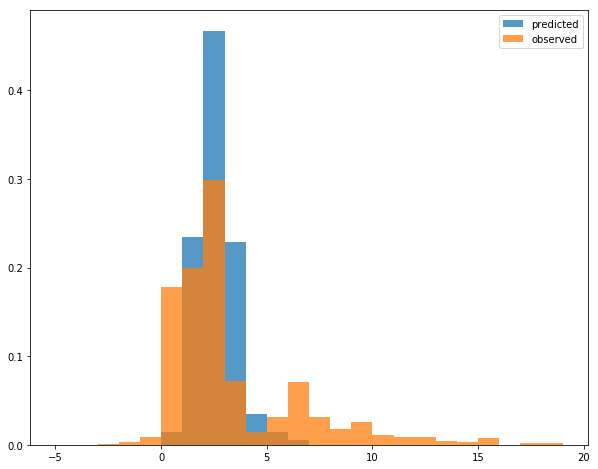

In [30]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

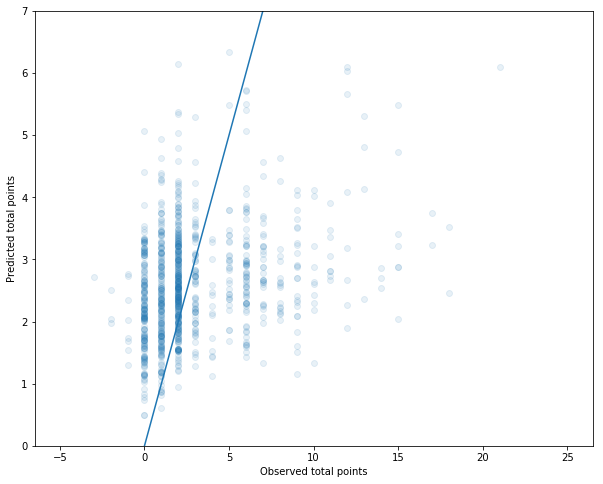

In [31]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((0, 7))
plt.show()

## Summary

In [32]:
pd.DataFrame([
    ('Neural network', test_loss[0], test_loss[1], test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Neural network,2.14083,9.519878,0.085227


In [33]:
pd.DataFrame([
    ('Neural network', test_loss_full[0], test_loss_full[1], test_loss_full[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Neural network,2.040644,8.315375,0.130969
